<a href="https://colab.research.google.com/github/aaronmj7/MSc_project/blob/main/Project_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project

In [2]:
pip install gensim

In [3]:
pip install shap

In [4]:
# Import neccessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud
from datetime import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
from sklearn.preprocessing import KBinsDiscretizer
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import Input, Dense, Embedding, Flatten, Concatenate
from keras.layers import Attention, GlobalAveragePooling1D, Reshape
from keras.layers import Dropout, Multiply, RepeatVector
from tensorflow.keras.regularizers import l2
from keras.utils import set_random_seed, plot_model
from keras.optimizers import Adam

from sklearn.metrics import mean_absolute_error


In [5]:
# Set plot theme
sns.set_theme(context='notebook', palette='husl', rc={'patch.edgecolor': 'k'})

# Set random seed
set_random_seed(73)

## Load Data

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Load movies.csv
movies_df = pd.read_csv('/content/drive/MyDrive/ml-32m/movies.csv')
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
# Load tags.csv
tags_df = pd.read_csv('/content/drive/MyDrive/ml-32m/tags.csv')
tags_df.head()

,userId,movieId,tag,timestamp
0,22,26479,Kevin Kline,1583038886
1,22,79592,misogyny,1581476297
2,22,247150,acrophobia,1622483469
3,34,2174,music,1249808064
4,34,2174,weird,1249808102


In [9]:
# Load ratings.csv
ratings_df = pd.read_csv('/content/drive/MyDrive/ml-32m/ratings.csv')
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


In [10]:
# Load links.csv
links_df = pd.read_csv('/content/drive/MyDrive/ml-32m/links.csv')
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


## EDA

In [11]:
# Display more info

print(movies_df.info(), '\n')
print(tags_df.info(), '\n')
print(ratings_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87585 entries, 0 to 87584
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  87585 non-null  int64 
 1   title    87585 non-null  object
 2   genres   87585 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.0+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000072 entries, 0 to 2000071
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   userId     int64 
 1   movieId    int64 
 2   tag        object
 3   timestamp  int64 
dtypes: int64(3), object(1)
memory usage: 61.0+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000204 entries, 0 to 32000203
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 976.6 MB
None


In [12]:
# Check null values
print('Null values\n\n', 'movies_df:')
print(movies_df.isnull().sum())
print('\ntags_df:')
print(tags_df.isnull().sum())
print('\nratings_df:')
print(ratings_df.isnull().sum())

Null values

 movies_df:
movieId    0
title      0
genres     0
dtype: int64

tags_df:
userId        0
movieId       0
tag          17
timestamp     0
dtype: int64

ratings_df:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [13]:
# Get rows with null values
tags_df[tags_df['tag'].isnull()]

,userId,movieId,tag,timestamp
185377,27046,33826,NaN,1221450908
1394089,89369,281500,NaN,1670942104
1914668,153443,123,NaN,1199450867
1914669,153443,346,NaN,1199451946
1914673,153443,1184,NaN,1199452261
1914680,153443,1785,NaN,1199452006
1914681,153443,2194,NaN,1199450677
1914683,153443,2691,NaN,1199451002
1914691,153443,4103,NaN,1199451920
1914693,153443,4473,NaN,1199451040


In [14]:
# Drop null values
tags_df.dropna(inplace=True)
tags_df.shape

(2000055, 4)

In [15]:
# Check for duplicates
print("Duplicates in movies_df:", movies_df.duplicated().sum())
print("Duplicates in tags_df:", tags_df.duplicated().sum())
print("Duplicates in ratings_df:", ratings_df.duplicated().sum())

Duplicates in movies_df: 0
Duplicates in tags_df: 0
Duplicates in ratings_df: 0


### movies_df

In [16]:
# Describe statistical info
movies_df.describe()

,movieId
count,87585.000000
mean,157651.365519
std,79013.402099
min,1.000000
25%,112657.000000
50%,165741.000000
75%,213203.000000
max,292757.000000


In [17]:
# Get value count of diferent genres
genre_count = movies_df['genres'].value_counts()
genre_count

,count
genres,
Drama,12443
Documentary,8132
Comedy,7761
(no genres listed),7080
Comedy|Drama,3245
...,...
Animation|Crime|Mystery|Sci-Fi|Thriller,1
Action|Comedy|Crime|Horror|Thriller,1
Adventure|Documentary|Drama|War,1


In [18]:
# Get all genres
all_genres = []
for genres in movies_df['genres']:
  all_genres.extend(genres.split('|'))

all_genres = pd.Series(all_genres)
genre_count = all_genres.value_counts()
genre_count

,count
Drama,34175
Comedy,23124
Thriller,11823
Romance,10369
Action,9668
Documentary,9363
Horror,8654
(no genres listed),7080
Crime,6976
Adventure,5402


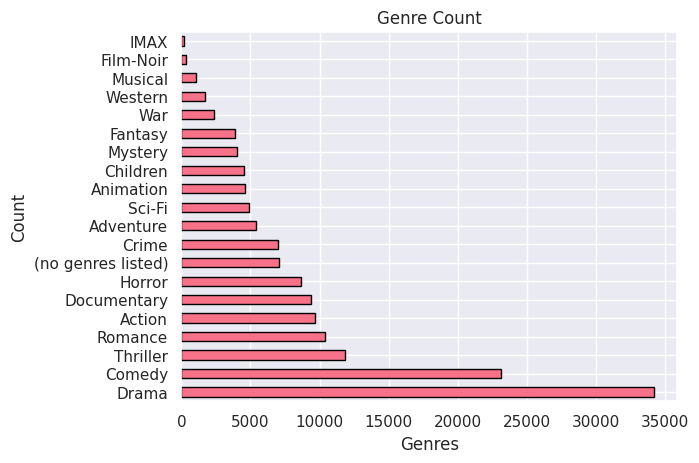

In [19]:
genre_count.plot(kind='barh')
plt.title('Genre Count')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.show()

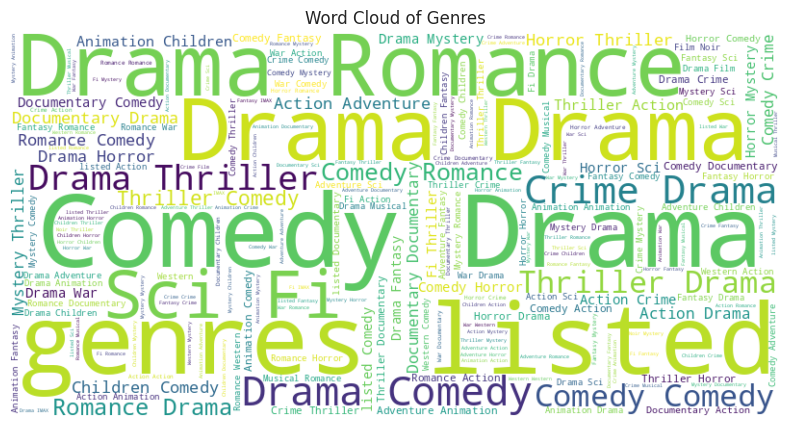

In [20]:
# Wordcloud
genre_text = ' '.join(all_genres)
wordcloud_genre = WordCloud(width=800, height=400, background_color='white').generate(genre_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_genre, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Genres')
plt.show()

### tags_df

In [21]:
# Describe statistical info
tags_df.describe()

,userId,movieId,timestamp
count,2.000055e+06,2.000055e+06,2.000055e+06
mean,8.192807e+04,7.189362e+04,1.528916e+09
std,3.810614e+04,7.480377e+04,1.290807e+08
min,2.200000e+01,1.000000e+00,1.135429e+09
25%,6.841300e+04,4.011000e+03,1.473615e+09
50%,7.821300e+04,5.232800e+04,1.574083e+09
75%,1.036980e+05,1.222940e+05,1.614740e+09
max,1.622790e+05,2.926290e+05,1.697155e+09


In [22]:
# Get value count of diferent tags
tags_count = tags_df['tag'].value_counts()
tags_count

,count
tag,
sci-fi,10996
atmospheric,9589
action,8473
comedy,8139
funny,7467
...,...
bad behavior,1
apache junction arizona,1
advent calendar,1


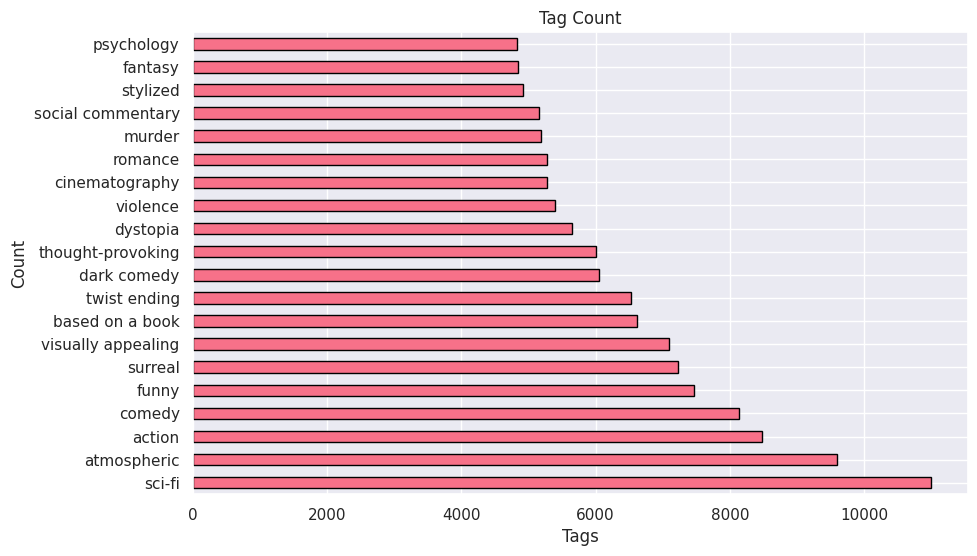

In [23]:
# plot tag counts
plt.figure(figsize=(10, 6))
tags_count[:20].plot(kind='barh')
plt.title('Tag Count')
plt.xlabel('Tags')
plt.ylabel('Count')
plt.show()

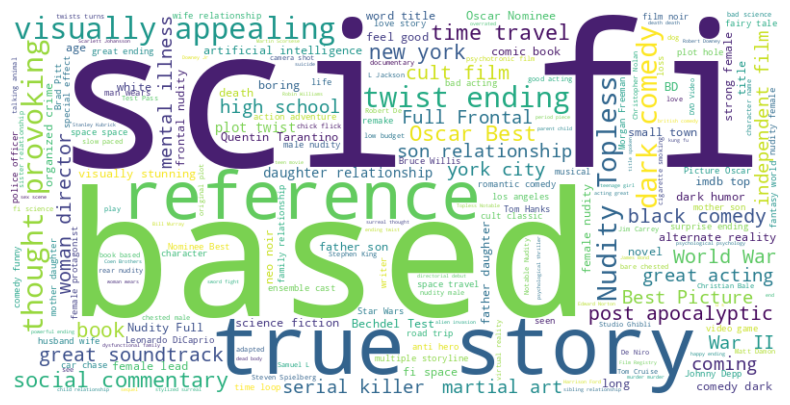

In [24]:
# Generate word cloud
all_tags = " ".join(tag for tag in tags_df['tag'].astype(str))
wordcloud_tags = WordCloud(width=800, height=400, background_color ='white').generate(all_tags)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_tags, interpolation='bilinear')
plt.axis("off")
plt.show()

### ratings_df

In [25]:
# Describe statistical info
ratings_df.describe()

,userId,movieId,rating,timestamp
count,3.200020e+07,3.200020e+07,3.200020e+07,3.200020e+07
mean,1.002785e+05,2.931861e+04,3.540396e+00,1.275241e+09
std,5.794905e+04,5.095816e+04,1.058986e+00,2.561630e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,7.896520e+08
25%,5.005300e+04,1.233000e+03,3.000000e+00,1.051012e+09
50%,1.002970e+05,3.452000e+03,3.500000e+00,1.272622e+09
75%,1.504510e+05,4.419900e+04,4.000000e+00,1.503158e+09
max,2.009480e+05,2.927570e+05,5.000000e+00,1.697164e+09


In [26]:
ratings_df['rating'].median()

3.5

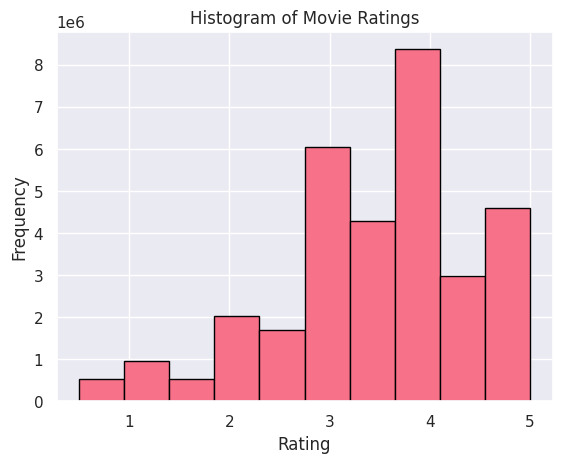

In [27]:
# Plot histogram of ratings
plt.hist(ratings_df['rating'])
plt.title('Histogram of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [28]:
# Get value count of diferent ratings
rating_count = ratings_df['rating'].value_counts().sort_index()
rating_count

,count
rating,
0.5,525132
1.0,946675
1.5,531063
2.0,2028622
2.5,1685386
3.0,6054990
3.5,4290105
4.0,8367654
4.5,2974000


In [29]:
rating_normalized_counts = ratings_df['rating'].value_counts(normalize=True).sort_index() * 100
rating_normalized_counts

,proportion
rating,
0.5,1.641027
1.0,2.958341
1.5,1.659561
2.0,6.339403
2.5,5.266798
3.0,18.921723
3.5,13.406493
4.0,26.148752
4.5,9.293691


In [30]:
rating_normalized_counts_rounded = rating_normalized_counts.round(1)
print(rating_normalized_counts_rounded)

rating
0.5     1.6
1.0     3.0
1.5     1.7
2.0     6.3
2.5     5.3
3.0    18.9
3.5    13.4
4.0    26.1
4.5     9.3
5.0    14.4
Name: proportion, dtype: float64


In [31]:
ratings_range = np.arange(0.5, 5.5, 0.5)
ratings_range

array([0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ])

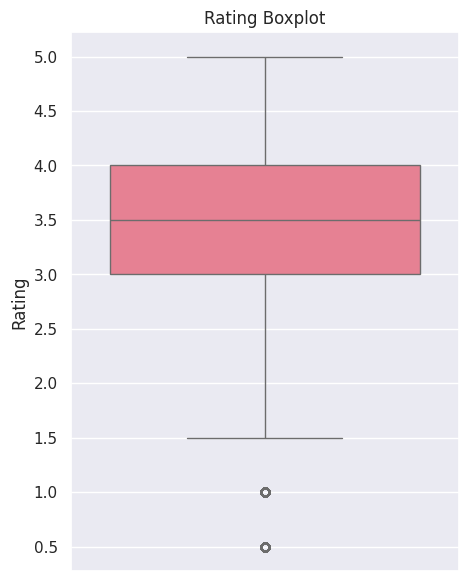

In [32]:
# Plot rating boxplot
plt.figure(figsize=(5, 7))
sns.boxplot(y=ratings_df['rating'])
plt.title('Rating Boxplot')
plt.yticks(ratings_range)
plt.ylabel('Rating')
plt.show()

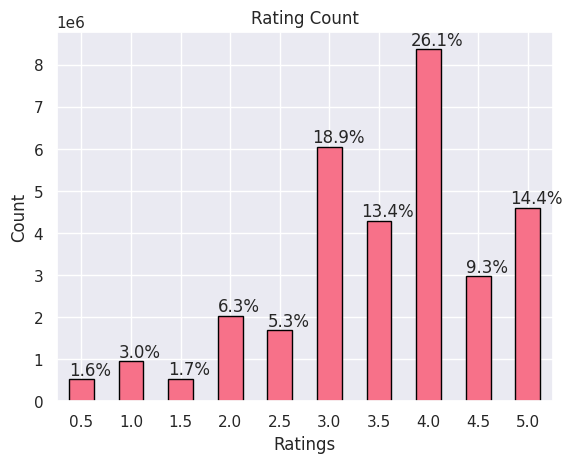

In [33]:
# Plot rating count
rating_count.plot(kind='bar')
plt.title('Rating Count')
plt.xticks(rotation=0)
plt.xlabel('Ratings')
plt.ylabel('Count')

# Add percentage labels on top of the bars
for i, v in enumerate(rating_count):
    percentage = rating_normalized_counts_rounded.iloc[i]
    plt.text(i + 0.175, v + 0.1e6, str(percentage) + '%', ha='center')

plt.savefig('rating_count.png', dpi=300, bbox_inches="tight")
plt.show()

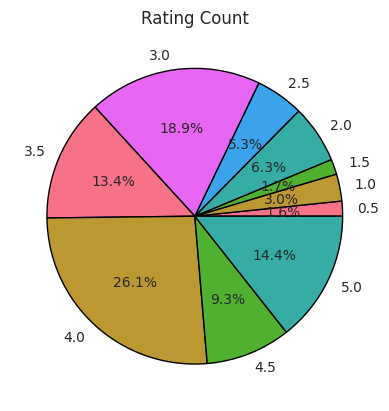

In [34]:
# Plot pie chart of rating count
rating_count.plot(kind='pie', autopct='%1.1f%%', fontsize=10, )
plt.title('Rating Count')
plt.ylabel('')
plt.show()

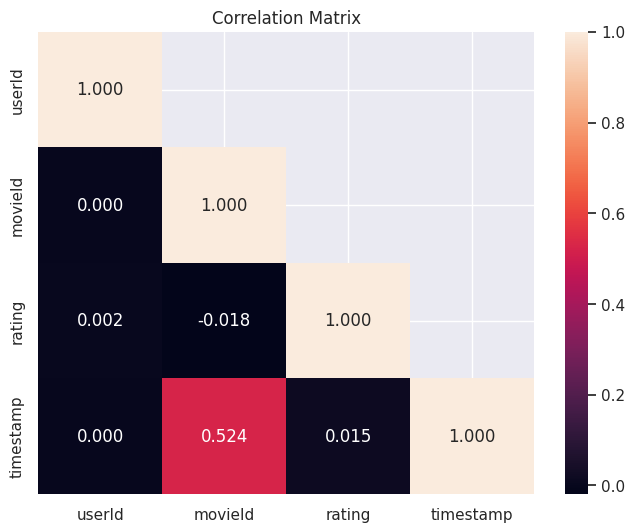

In [35]:
# Correlation matrix
corr = ratings_df.corr()

# Generate a mask
mask = np.triu(np.ones_like(corr, dtype=bool), k=1)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".3f", mask=mask)
plt.grid('off')
plt.title('Correlation Matrix')
plt.show()

Only movieId and timestamp have correlation. This might be due to Id increasing with new movies

## Data Pre-processing

### Getting genres

In [36]:
# Replace '|' with ',' in the 'genre' column
movies_df['genres'] = movies_df['genres'].str.replace('|', ',')
movies_df

,movieId,title,genres
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy"
1,2,Jumanji (1995),"Adventure,Children,Fantasy"
2,3,Grumpier Old Men (1995),"Comedy,Romance"
3,4,Waiting to Exhale (1995),"Comedy,Drama,Romance"
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
87580,292731,The Monroy Affaire (2022),Drama
87581,292737,Shelter in Solitude (2023),"Comedy,Drama"
87582,292753,Orca (2023),Drama
87583,292755,The Angry Breed (1968),Drama


In [37]:
movies_df = movies_df[movies_df['genres'] != '(no genres listed)']
movies_df

,movieId,title,genres
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy"
1,2,Jumanji (1995),"Adventure,Children,Fantasy"
2,3,Grumpier Old Men (1995),"Comedy,Romance"
3,4,Waiting to Exhale (1995),"Comedy,Drama,Romance"
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
87580,292731,The Monroy Affaire (2022),Drama
87581,292737,Shelter in Solitude (2023),"Comedy,Drama"
87582,292753,Orca (2023),Drama
87583,292755,The Angry Breed (1968),Drama


In [38]:
# Calculate the number of genres for each movie
movies_df.loc[:, 'genre_count'] = movies_df['genres'].str.split(',').str.len()
movies_df

<ipython-input-38-bd7a9711ac96>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_df.loc[:, 'genre_count'] = movies_df['genres'].str.split(',').str.len()


,movieId,title,genres,genre_count
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy",5
1,2,Jumanji (1995),"Adventure,Children,Fantasy",3
2,3,Grumpier Old Men (1995),"Comedy,Romance",2
3,4,Waiting to Exhale (1995),"Comedy,Drama,Romance",3
4,5,Father of the Bride Part II (1995),Comedy,1
...,...,...,...,...
87580,292731,The Monroy Affaire (2022),Drama,1
87581,292737,Shelter in Solitude (2023),"Comedy,Drama",2
87582,292753,Orca (2023),Drama,1
87583,292755,The Angry Breed (1968),Drama,1


In [39]:
movies_df['genre_count'].describe()

,genre_count
count,80505.000000
mean,1.827091
std,0.955556
min,1.000000
25%,1.000000
50%,2.000000
75%,2.000000
max,10.000000


In [40]:
# Calculate the percentage of movies with different numbers of genres
genre_counts = movies_df['genre_count'].value_counts(normalize=True) * 100
genre_counts

,proportion
genre_count,
1,46.587168
2,31.379417
3,16.361717
4,4.373641
5,1.054593
6,0.199988
7,0.039749
8,0.002484
10,0.001242


In [41]:
# Create a dictionary to store the percentages
genre_percentages = {}

# Iterate through the possible genre counts and store their percentages
for i in range(1, 6):
    genre_percentages[i] = genre_counts.get(i, 0)

# Handle movies with 6 or more genres
genre_percentages['6 or more'] = genre_counts[genre_counts.index >= 6].sum()

# Print the results
for count, percentage in genre_percentages.items():
    print(f"Percentage of movies with {count} genre(s): {percentage:.2f}%")

Percentage of movies with 1 genre(s): 46.59%
Percentage of movies with 2 genre(s): 31.38%
Percentage of movies with 3 genre(s): 16.36%
Percentage of movies with 4 genre(s): 4.37%
Percentage of movies with 5 genre(s): 1.05%
Percentage of movies with 6 or more genre(s): 0.24%


In [42]:
movies_df[movies_df['genre_count'] >= 6]['genres']

,genres
196,"Action,Crime,Drama,Mystery,Sci-Fi,Thriller"
359,"Adventure,Animation,Children,Drama,Musical,IMAX"
454,"Action,Adventure,Crime,Drama,Romance,Thriller"
540,"Action,Adventure,Children,Comedy,Fantasy,Sci-Fi"
587,"Animation,Children,Fantasy,Musical,Romance,IMAX"
...,...
84413,"Adventure,Animation,Children,Comedy,Fantasy,Ro..."
85543,"Adventure,Animation,Children,Comedy,Fantasy,Ro..."
85621,"Action,Adventure,Drama,Fantasy,Mystery,Romance..."
86395,"Action,Adventure,Drama,Horror,Mystery,Thriller"


In [43]:
movies_df = movies_df[movies_df['genre_count'] <= 5]
movies_df

,movieId,title,genres,genre_count
0,1,Toy Story (1995),"Adventure,Animation,Children,Comedy,Fantasy",5
1,2,Jumanji (1995),"Adventure,Children,Fantasy",3
2,3,Grumpier Old Men (1995),"Comedy,Romance",2
3,4,Waiting to Exhale (1995),"Comedy,Drama,Romance",3
4,5,Father of the Bride Part II (1995),Comedy,1
...,...,...,...,...
87580,292731,The Monroy Affaire (2022),Drama,1
87581,292737,Shelter in Solitude (2023),"Comedy,Drama",2
87582,292753,Orca (2023),Drama,1
87583,292755,The Angry Breed (1968),Drama,1


### Tags per movies

In [44]:
# Normalize tags (lowercase and strip extra spaces)
def normalize_tag(tag):
    # Convert all entries to string
    tag = str(tag).lower()  # Convert to lowercase
    return ' '.join(tag.split())  # Remove extra spaces

# Apply normalization
tags_df['tag'] = tags_df['tag'].apply(normalize_tag)
tags_df

,userId,movieId,tag,timestamp
0,22,26479,kevin kline,1583038886
1,22,79592,misogyny,1581476297
2,22,247150,acrophobia,1622483469
3,34,2174,music,1249808064
4,34,2174,weird,1249808102
...,...,...,...,...
2000067,162279,90645,rafe spall,1320817734
2000068,162279,91079,anton yelchin,1322337407
2000069,162279,91079,felicity jones,1322337400
2000070,162279,91658,rooney mara,1325828398


In [45]:
movie_tag_counts = tags_df.groupby('movieId').size().reset_index(name='tag_count')

movie_tag_counts.set_index('movieId', inplace=True)

movie_tag_counts

,tag_count
movieId,
1,1230
2,573
3,23
4,12
5,64
...,...
292143,12
292349,1
292371,1


In [46]:
movie_tag_counts.describe()

,tag_count
count,51323.000000
mean,38.969955
std,160.935295
min,1.000000
25%,2.000000
50%,5.000000
75%,16.000000
max,6697.000000


In [47]:
movie_tag_counts['tag_count'].median()

5.0

In [48]:
# Calculate the percentage of movies with 5 or less tags
percentage_5_or_less_tags = (movie_tag_counts[movie_tag_counts['tag_count'] <= 5].shape[0] / movie_tag_counts.shape[0]) * 100
print(f"Percentage of movies with 5 or less tags: {percentage_5_or_less_tags:.2f}%")

Percentage of movies with 5 or less tags: 50.15%


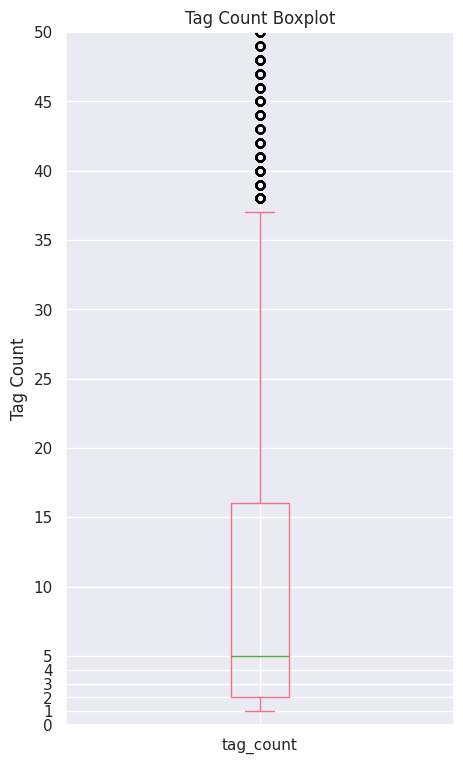

In [49]:
plt.figure(figsize=(5, 9))
movie_tag_counts['tag_count'].plot(kind='box')
plt.title('Tag Count Boxplot')
plt.ylabel('Tag Count')
plt.ylim(0, 50)
ticks = np.hstack([np.arange(0, 6), np.arange(10, 51, 5)])
plt.yticks(ticks)
plt.show()

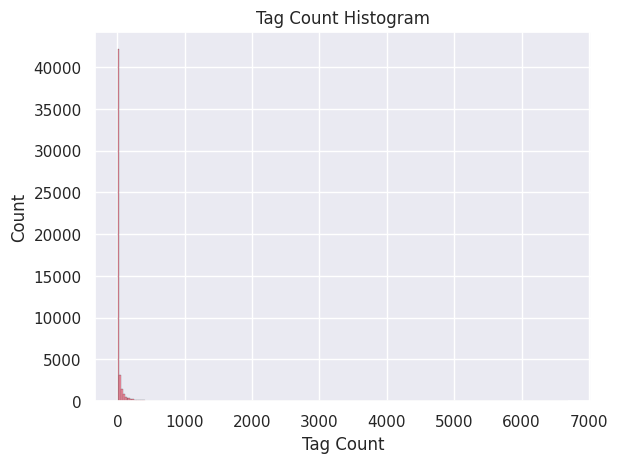

In [50]:
sns.histplot(movie_tag_counts['tag_count'], bins=250)
plt.xlabel('Tag Count')
plt.ylabel('Count')
plt.title('Tag Count Histogram')
plt.show()

In [51]:
# Count the occurrences of each tag for each movie
tag_counts_df = tags_df.groupby(['movieId', 'tag']).size().reset_index(name='each_tag_count')

tag_counts_df

,movieId,tag,each_tag_count
0,1,1990s,1
1,1,2009 reissue in stereoscopic 3-d,1
2,1,3 dimensional,1
3,1,3d,4
4,1,55 movies every kid should see--entertainment ...,1
...,...,...,...
1071023,292349,politically incorrect,1
1071024,292371,stephen king,1
1071025,292597,artificial intelligence,1
1071026,292629,documentary filmmaking,1


In [52]:
tag_counts_df.sort_values(by=['movieId', 'each_tag_count'], ascending=[True, False])

,movieId,tag,each_tag_count
277,1,pixar,131
18,1,animation,78
129,1,disney,57
183,1,funny,50
365,1,tom hanks,48
...,...,...,...
1071023,292349,politically incorrect,1
1071024,292371,stephen king,1
1071025,292597,artificial intelligence,1
1071026,292629,documentary filmmaking,1


In [53]:
tag_counts_df['each_tag_count'].describe()

,each_tag_count
count,1.071028e+06
mean,1.867416e+00
std,5.393436e+00
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,6.030000e+02


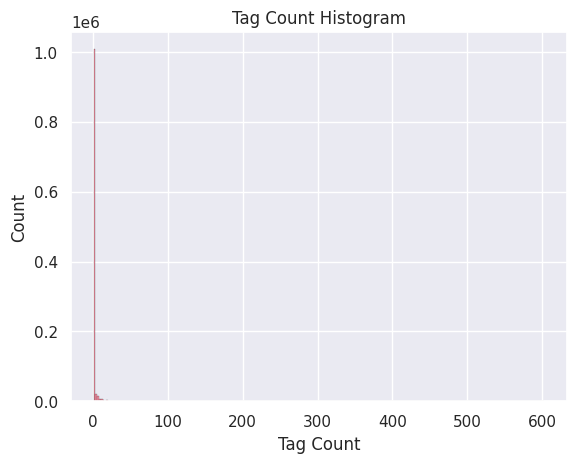

In [54]:
sns.histplot(tag_counts_df['each_tag_count'], bins=250)
plt.xlabel('Tag Count')
plt.ylabel('Count')
plt.title('Tag Count Histogram')
plt.show()

In [55]:
# Take the top n tags for each movie
n = 5
top_tags_df = tag_counts_df.groupby('movieId').head(n)

# Aggregate top tags into a single string for each movie
top_tags_df = top_tags_df.groupby('movieId')['tag'].apply(lambda tags: ','.join(tags)).reset_index()
top_tags_df.columns = ['movieId', 'top_tags']
top_tags_df

,movieId,top_tags
0,1,"1990s,2009 reissue in stereoscopic 3-d,3 dimen..."
1,2,"1860s,1960s,1990s,19th century,20th century"
2,3,"best friend,clv,comedinha de velhinhos engraã§..."
3,4,"based on novel or book,characters,chick flick,..."
4,5,"4th wall,aging,baby,clv,comedy"
...,...,...
51318,292143,"cadaqués,catalonia,china,housing estate,husban..."
51319,292349,politically incorrect
51320,292371,stephen king
51321,292597,artificial intelligence


### Average ratings

In [56]:
# Calculate the average rating for each movie
average_ratings_df = ratings_df.groupby('movieId')['rating'].mean().reset_index()

# Set movieId as index
average_ratings_df.set_index('movieId', inplace=True)

# Display average ratings
average_ratings_df.head()

,rating
movieId,
1,3.897438
2,3.275758
3,3.139447
4,2.845331
5,3.059602


In [57]:
average_ratings_df.describe()

,rating
count,84432.000000
mean,3.005082
std,0.801820
min,0.500000
25%,2.543478
50%,3.071429
75%,3.500000
max,5.000000


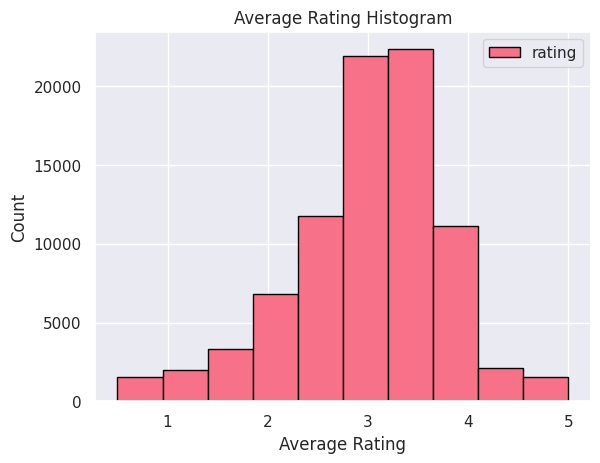

In [58]:
# Plot
average_ratings_df.plot(kind='hist', bins=10)
plt.xlabel('Average Rating')
plt.ylabel('Count')
plt.title('Average Rating Histogram')
plt.show()

In [59]:
# Round the average ratings to the nearest 0.5
average_ratings_df['rating'] = (average_ratings_df['rating'] * 2).round() / 2

average_ratings_df.head()

,rating
movieId,
1,4.0
2,3.5
3,3.0
4,3.0
5,3.0


In [60]:
average_ratings_df.describe()

,rating
count,84432.000000
mean,3.004968
std,0.811505
min,0.500000
25%,2.500000
50%,3.000000
75%,3.500000
max,5.000000


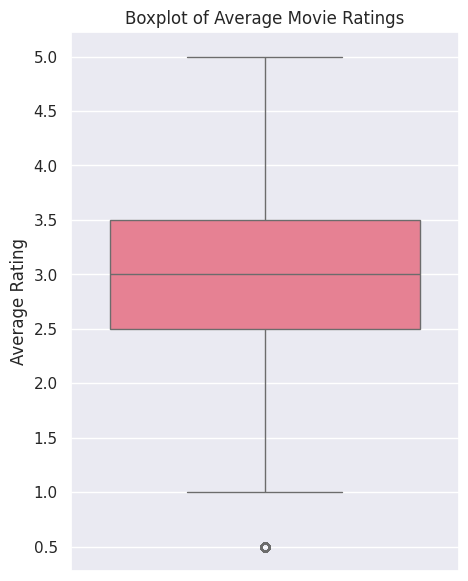

In [61]:
# Plot the boxplot
plt.figure(figsize=(5, 7))
sns.boxplot(y=average_ratings_df['rating'])
plt.title('Boxplot of Average Movie Ratings')
plt.ylabel('Average Rating')
plt.yticks(ratings_range)
plt.show()

In [62]:
average_rating_count = average_ratings_df['rating'].value_counts().sort_index()
average_rating_count

,count
rating,
0.5,1324
1.0,1912
1.5,2474
2.0,7607
2.5,12050
3.0,25611
3.5,21349
4.0,9390
4.5,1196


In [63]:
# Calculate percentages
average_rating_normalized_counts = pd.crosstab(index=average_ratings_df['rating'], columns='percentage', normalize=True) * 100
average_rating_normalized_counts

col_0,percentage
rating,
0.5,1.568126
1.0,2.264544
1.5,2.930169
2.0,9.009617
2.5,14.271840
3.0,30.333286
3.5,25.285437
4.0,11.121376
4.5,1.416525


In [64]:
type(average_rating_normalized_counts.iloc[1,0])

numpy.float64

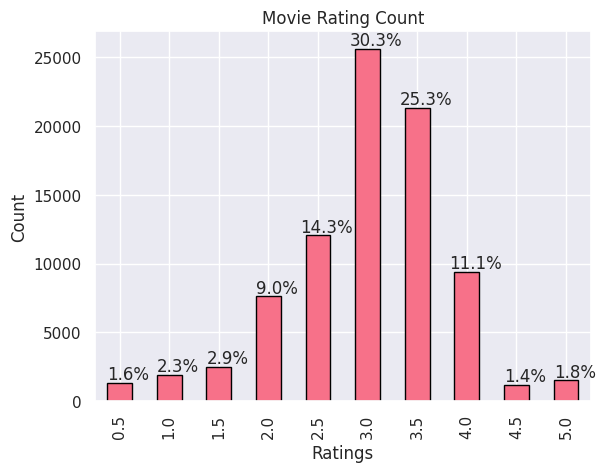

In [65]:
average_rating_count.plot(kind='bar', edgecolor='k')
plt.title('Movie Rating Count')
plt.xlabel('Ratings')
plt.ylabel('Count')

# Add percentage labels on top of the bars
for i, v in enumerate(average_rating_count):
    percentage = np.round((average_rating_normalized_counts.iloc[i,0]), 1)
    plt.text(i + 0.175, v + 250, str(percentage) + '%', ha='center')

plt.savefig('movie_rating_count.png', dpi=300, bbox_inches="tight")
plt.show()

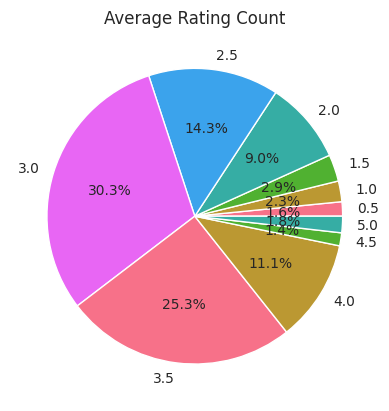

In [66]:
# Pie chart of average ratings
average_rating_count.plot(kind='pie', autopct='%1.1f%%', fontsize=10, wedgeprops={'edgecolor': 'white'})
plt.title('Average Rating Count')
plt.ylabel('')
plt.show()

### Final df

In [67]:
# Merge the top tags with average_ratings_df
movies_with_ratings_and_tags_df = pd.merge(average_ratings_df, top_tags_df, on='movieId', how='left')

movies_with_ratings_and_tags_df

,movieId,rating,top_tags
0,1,4.0,"1990s,2009 reissue in stereoscopic 3-d,3 dimen..."
1,2,3.5,"1860s,1960s,1990s,19th century,20th century"
2,3,3.0,"best friend,clv,comedinha de velhinhos engraã§..."
3,4,3.0,"based on novel or book,characters,chick flick,..."
4,5,3.0,"4th wall,aging,baby,clv,comedy"
...,...,...,...
84427,292731,4.0,NaN
84428,292737,1.5,NaN
84429,292753,4.0,NaN
84430,292755,1.0,NaN


In [68]:
# Merge movies_with_ratings_and_tags_df with genres from movies_df
final_df = pd.merge(movies_with_ratings_and_tags_df, movies_df[['movieId', 'genres']], on='movieId', how='left')
final_df

,movieId,rating,top_tags,genres
0,1,4.0,"1990s,2009 reissue in stereoscopic 3-d,3 dimen...","Adventure,Animation,Children,Comedy,Fantasy"
1,2,3.5,"1860s,1960s,1990s,19th century,20th century","Adventure,Children,Fantasy"
2,3,3.0,"best friend,clv,comedinha de velhinhos engraã§...","Comedy,Romance"
3,4,3.0,"based on novel or book,characters,chick flick,...","Comedy,Drama,Romance"
4,5,3.0,"4th wall,aging,baby,clv,comedy",Comedy
...,...,...,...,...
84427,292731,4.0,NaN,Drama
84428,292737,1.5,NaN,"Comedy,Drama"
84429,292753,4.0,NaN,Drama
84430,292755,1.0,NaN,Drama


In [69]:
final_df.dropna(inplace=True)
final_df

,movieId,rating,top_tags,genres
0,1,4.0,"1990s,2009 reissue in stereoscopic 3-d,3 dimen...","Adventure,Animation,Children,Comedy,Fantasy"
1,2,3.5,"1860s,1960s,1990s,19th century,20th century","Adventure,Children,Fantasy"
2,3,3.0,"best friend,clv,comedinha de velhinhos engraã§...","Comedy,Romance"
3,4,3.0,"based on novel or book,characters,chick flick,...","Comedy,Drama,Romance"
4,5,3.0,"4th wall,aging,baby,clv,comedy",Comedy
...,...,...,...,...
84348,292033,3.0,neighbor,"Comedy,Drama"
84360,292057,2.0,illegal immigration,Drama
84379,292349,3.0,politically incorrect,"Comedy,Horror"
84389,292371,2.5,stephen king,"Fantasy,Horror"


In [70]:
final_df.sort_values(by='movieId', inplace=True)
final_df.reset_index(drop=True, inplace=True)
final_df

,movieId,rating,top_tags,genres
0,1,4.0,"1990s,2009 reissue in stereoscopic 3-d,3 dimen...","Adventure,Animation,Children,Comedy,Fantasy"
1,2,3.5,"1860s,1960s,1990s,19th century,20th century","Adventure,Children,Fantasy"
2,3,3.0,"best friend,clv,comedinha de velhinhos engraã§...","Comedy,Romance"
3,4,3.0,"based on novel or book,characters,chick flick,...","Comedy,Drama,Romance"
4,5,3.0,"4th wall,aging,baby,clv,comedy",Comedy
...,...,...,...,...
45886,292033,3.0,neighbor,"Comedy,Drama"
45887,292057,2.0,illegal immigration,Drama
45888,292349,3.0,politically incorrect,"Comedy,Horror"
45889,292371,2.5,stephen king,"Fantasy,Horror"


In [71]:
final_df['rating'].describe()

,rating
count,45891.000000
mean,3.074317
std,0.661412
min,0.500000
25%,3.000000
50%,3.000000
75%,3.500000
max,5.000000


In [72]:
final_df['rating'].value_counts().sort_index()

,count
rating,
0.5,266
1.0,456
1.5,860
2.0,3166
2.5,6705
3.0,15035
3.5,14073
4.0,4757
4.5,287


### Time trend

In [73]:
# Convert timestamps to datetime
tags_df['datetime'] = pd.to_datetime(tags_df['timestamp'], unit='s')
ratings_df['datetime'] = pd.to_datetime(ratings_df['timestamp'], unit='s')

# Add year column to both dataframes
tags_df['year'] = tags_df['datetime'].dt.year
ratings_df['year'] = ratings_df['datetime'].dt.year
ratings_df['month'] = ratings_df['datetime'].dt.to_period('M')  # Year-Month format
ratings_df

,userId,movieId,rating,timestamp,datetime,year,month
0,1,17,4.0,944249077,1999-12-03 19:24:37,1999,1999-12
1,1,25,1.0,944250228,1999-12-03 19:43:48,1999,1999-12
2,1,29,2.0,943230976,1999-11-22 00:36:16,1999,1999-11
3,1,30,5.0,944249077,1999-12-03 19:24:37,1999,1999-12
4,1,32,5.0,943228858,1999-11-22 00:00:58,1999,1999-11
...,...,...,...,...,...,...,...
32000199,200948,79702,4.5,1294412589,2011-01-07 15:03:09,2011,2011-01
32000200,200948,79796,1.0,1287216292,2010-10-16 08:04:52,2010,2010-10
32000201,200948,80350,0.5,1294412671,2011-01-07 15:04:31,2011,2011-01
32000202,200948,80463,3.5,1350423800,2012-10-16 21:43:20,2012,2012-10


In [74]:
# Average Rating Trends
monthly_ratings = ratings_df.set_index('datetime').resample('ME')['rating'].mean()

# Compute metrics for overall ratings
highest_monthly_avg = monthly_ratings.idxmax(), monthly_ratings.max()
lowest_monthly_avg = monthly_ratings.idxmin(), monthly_ratings.min()
overall_trend = (monthly_ratings.iloc[-1] - monthly_ratings.iloc[0]) / len(monthly_ratings)

print(f"Highest Monthly Average: {highest_monthly_avg}")
print(f"Lowest Monthly Average: {lowest_monthly_avg}")
print(f"Overall Trend: {overall_trend:.4f} per month")

Highest Monthly Average: (Timestamp('1996-01-31 00:00:00'), 4.166666666666667)
Lowest Monthly Average: (Timestamp('2002-08-31 00:00:00'), 3.363400229671351)
Overall Trend: -0.0007 per month


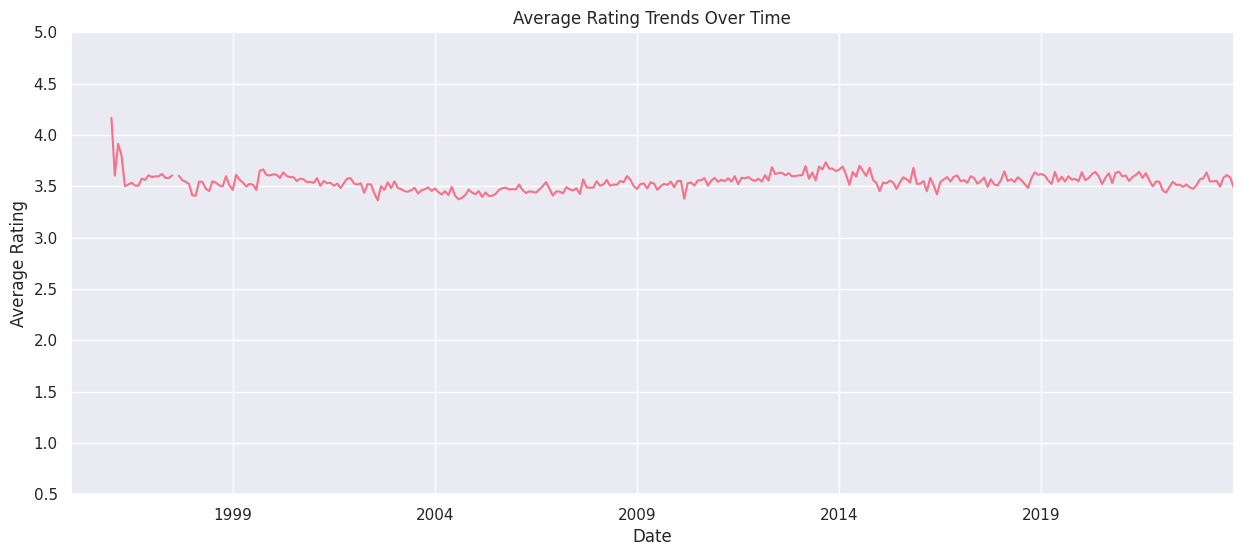

In [75]:
# Plot the average rating trends
plt.figure(figsize=(15, 6))
monthly_ratings.plot()
plt.title('Average Rating Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Average Rating')
plt.yticks(ratings_range)
plt.savefig('average_rating_trends.png', dpi=300, bbox_inches="tight")
plt.show()

In [76]:
# Pre-split genres separated by "|" into individual rows
expanded_genres_df = final_df[['movieId', 'rating', 'genres']].copy()
expanded_genres_df['genres'] = expanded_genres_df['genres'].str.split(',')  # Split genres on "|"
expanded_genres_df = expanded_genres_df.explode('genres')  # Expand each genre into a separate row

# Merge with year information
expanded_genres_df = expanded_genres_df.merge(
    ratings_df[['movieId', 'year']].drop_duplicates(),
    on='movieId',
    how='left'
)

# Calculate metrics for all genres
genre_trends = (
    expanded_genres_df.groupby(['genres', 'year'])
    .agg(
        average_rating=('rating', 'mean'),
        volatility=('rating', 'std'),
        rating_count=('rating', 'size')
    )
    .reset_index()
)

# Add a column for rating change (trend points per year)
genre_trends['rating_change'] = genre_trends.groupby('genres')['average_rating'].diff()

# Calculate overall statistics for each genre
genre_summary = (
    genre_trends.groupby('genres')
    .agg(
        avg_rating=('average_rating', 'mean'),
        max_rating=('average_rating', 'max'),
        min_rating=('average_rating', 'min'),
        max_volatility=('volatility', 'max'),
        avg_volatility=('volatility', 'mean'),
        total_ratings=('rating_count', 'sum'),
        avg_rating_change=('rating_change', 'mean')
    )
    .reset_index()
)



In [77]:
# Sort genres by total ratings for better visibility
genre_summary = genre_summary.sort_values(by='total_ratings', ascending=False)

# Display the summarized statistics for genres
genre_summary


,genres,avg_rating,max_rating,min_rating,max_volatility,avg_volatility,total_ratings,avg_rating_change
7,Drama,3.380661,4.000000,3.270579,0.504638,0.460311,188887,-0.024881
4,Comedy,3.155168,3.750000,3.098228,0.555909,0.530380,127298,-0.022124
16,Thriller,3.170197,3.750000,3.022179,0.553098,0.510056,68825,-0.024365
14,Romance,3.328136,4.000000,3.218048,0.518593,0.474390,60780,-0.026900
0,Action,3.063528,3.194595,2.995645,0.593736,0.560865,55581,-0.005472
10,Horror,2.834542,3.039326,2.715173,0.606113,0.573979,44413,-0.008535
5,Crime,3.305106,3.750000,3.193204,0.547450,0.495338,43062,-0.018213
1,Adventure,3.154093,3.345070,3.075544,0.598400,0.557702,36101,-0.008216
15,Sci-Fi,3.002977,3.292683,2.844101,0.660885,0.599685,30419,-0.013698
6,Documentary,3.510022,3.561404,3.455090,0.517252,0.459503,26475,-0.001299


In [78]:
# Find the most volatile genre
most_volatile_genre = genre_summary.loc[genre_summary['avg_volatility'].idxmax()]

# Find the most stable genre
most_stable_genre = genre_summary.loc[genre_summary['avg_volatility'].idxmin()]

# Find the most declining genre
most_declining_genre = genre_summary.loc[genre_summary['avg_rating_change'].idxmin()]

# Find the most increasing genre
most_increasing_genre = genre_summary.loc[genre_summary['avg_rating_change'].idxmax()]

print(f"Most Volatile Genre:\n{most_volatile_genre}\n")
print(f"Most Stable Genre:\n{most_stable_genre}\n")
print(f"Most Declining Genre:\n{most_declining_genre}\n")
print(f"Most Increasing Genre:\n{most_increasing_genre}")

Most Volatile Genre:
genres                 Sci-Fi
avg_rating           3.002977
max_rating           3.292683
min_rating           2.844101
max_volatility       0.660885
avg_volatility       0.599685
total_ratings           30419
avg_rating_change   -0.013698
Name: 15, dtype: object

Most Stable Genre:
genres               Film-Noir
avg_rating            3.589474
max_rating            3.782609
min_rating            3.350153
max_volatility        0.500533
avg_volatility        0.385647
total_ratings             4461
avg_rating_change    -0.010138
Name: 9, dtype: object

Most Declining Genre:
genres                Fantasy
avg_rating           3.188706
max_rating                4.0
min_rating           3.067271
max_volatility       0.593029
avg_volatility       0.554235
total_ratings           22662
avg_rating_change   -0.031751
Name: 8, dtype: object

Most Increasing Genre:
genres               Documentary
avg_rating              3.510022
max_rating              3.561404
min_rating     

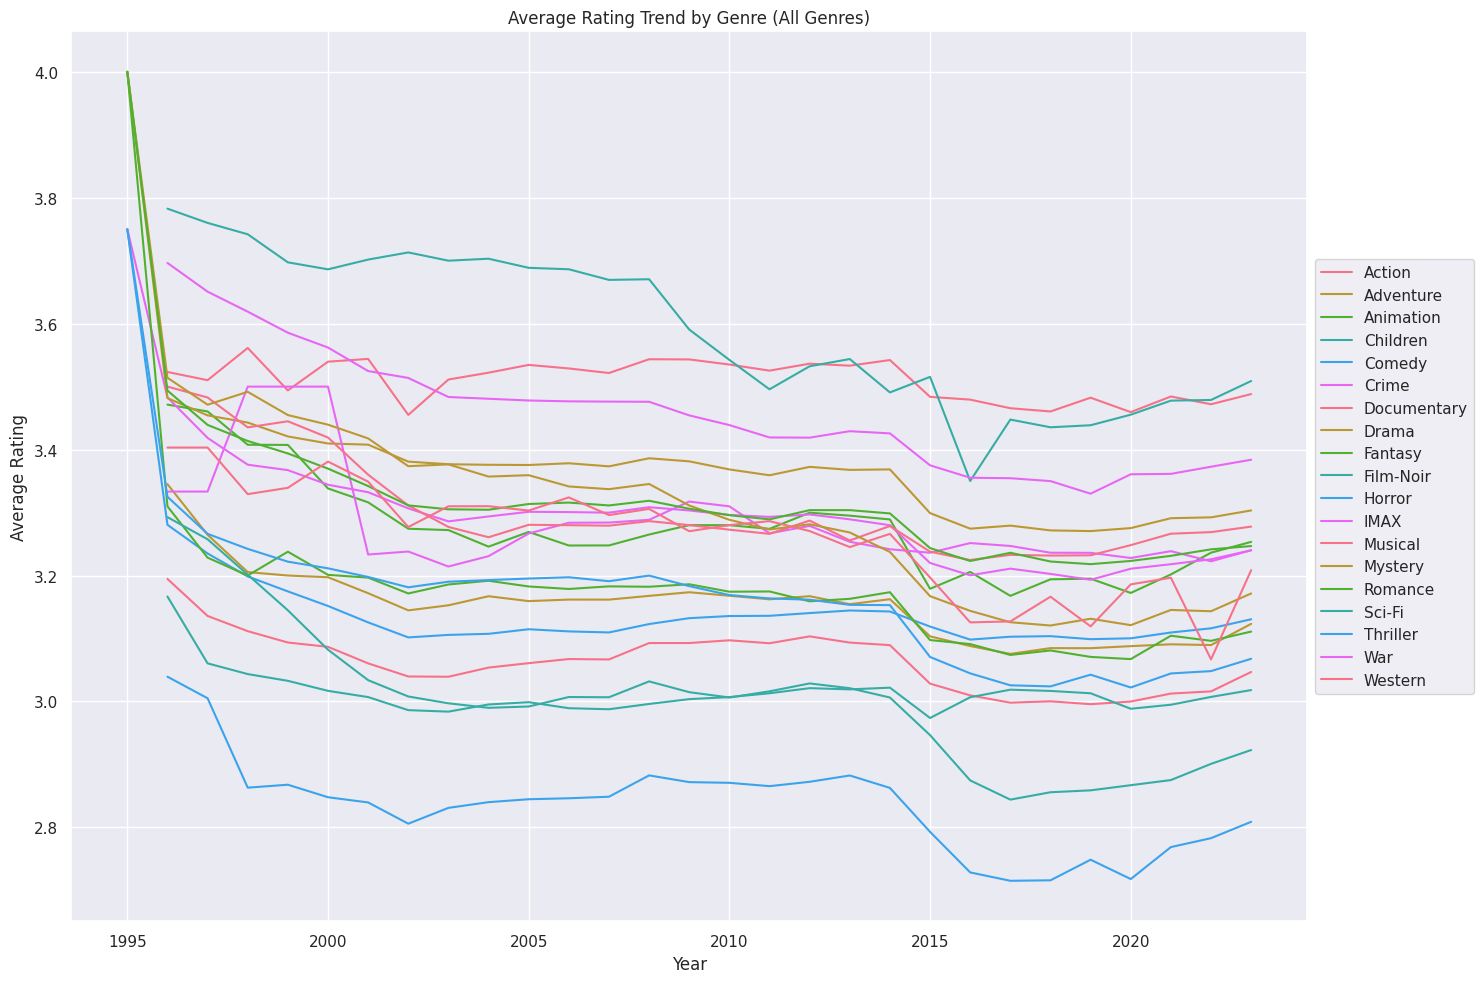

In [79]:
# Plot all genres' trends
plt.figure(figsize=(15, 10))
for genre in genre_trends['genres'].unique():
    subset = genre_trends[genre_trends['genres'] == genre]
    plt.plot(subset['year'], subset['average_rating'], label=genre)

plt.title('Average Rating Trend by Genre (All Genres)')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.grid(True)
plt.tight_layout()
plt.show()

### Genre-Tag Correlation

In [80]:
import re
from itertools import product

# Flatten genres and tags for vectorized operations
expanded_genres = final_df[['movieId', 'genres']].copy()
expanded_genres['genres'] = expanded_genres['genres'].str.split(',')  # Split genres by ','
expanded_genres = expanded_genres.explode('genres')  # Expand genres into separate rows

expanded_tags = final_df[['movieId', 'top_tags']].copy()
expanded_tags['top_tags'] = expanded_tags['top_tags'].str.split(',')  # Split tags by ','
expanded_tags = expanded_tags.explode('top_tags')  # Expand tags into separate rows

# Merge genres and tags
genre_tag_df = expanded_genres.merge(expanded_tags, on='movieId', how='inner')

# Clean genres and tags
genre_tag_df['genres'] = genre_tag_df['genres'].str.strip()
genre_tag_df['top_tags'] = genre_tag_df['top_tags'].str.strip()

# Count occurrences of each genre-tag pair
genre_tag_counts = (
    genre_tag_df.groupby(['genres', 'top_tags'])
    .size()
    .reset_index(name='count')
)

# Count total occurrences of each genre
genre_counts = (
    genre_tag_df.groupby('genres')
    .size()
    .reset_index(name='total_genre_movies')
)

# Merge counts and calculate correlation
genre_tag_correlation_df = genre_tag_counts.merge(genre_counts, on='genres', how='left')
genre_tag_correlation_df['correlation'] = genre_tag_correlation_df['count'] / genre_tag_correlation_df['total_genre_movies']

# Sort by correlation
genre_tag_correlation_df = genre_tag_correlation_df.sort_values(by='correlation', ascending=False)

# Display top 10 correlations
genre_tag_correlation_df.head(20)


,genres,top_tags,count,total_genre_movies,correlation
63923,Film-Noir,bd-r,136,1479,0.091954
64163,Film-Noir,film noir,117,1479,0.079108
71042,IMAX,action,61,859,0.071013
12913,Animation,animation,519,9248,0.056120
71919,Musical,bd-r,224,4091,0.054754
70961,IMAX,3d,45,859,0.052386
72830,Musical,musical,206,4091,0.050354
101197,Western,bd-r,192,4055,0.047349
70969,IMAX,4k,40,859,0.046566
39544,Documentary,documentary,683,15888,0.042988


### Strings to vectors

In [81]:
'''# Initialise tokenizers
tokenizer_tags = Tokenizer(filters='', lower=True)
tokenizer_genres = Tokenizer(filters='', lower=True)

# Function to clean and split comma-separated items
def clean_and_split(x):
    if isinstance(x, list):
        # Join list items and split by comma
        return [item.strip() for item in ','.join(x).split(',')]
    elif isinstance(x, str):
        # Split string by comma
        return [item.strip() for item in x.split(',')]
    return []

# Fit tokenizers on cleaned text
tokenizer_tags.fit_on_texts(final_df['top_tags'].apply(clean_and_split))
tokenizer_genres.fit_on_texts(final_df['genres'].apply(clean_and_split))

# Convert to sequences
tag_sequences = tokenizer_tags.texts_to_sequences(final_df['top_tags'].apply(clean_and_split))
genre_sequences = tokenizer_genres.texts_to_sequences(final_df['genres'].apply(clean_and_split))

# Verify tokenization
print("\nSample of genre vocabulary:")
print({v: k for k, v in tokenizer_genres.word_index.items()})
print("\nSample of tag vocabulary:")
print({v: k for k, v in tokenizer_tags.word_index.items()})'''

'# Initialise tokenizers\ntokenizer_tags = Tokenizer(filters=\'\', lower=True)\ntokenizer_genres = Tokenizer(filters=\'\', lower=True)\n\n# Function to clean and split comma-separated items\ndef clean_and_split(x):\n    if isinstance(x, list):\n        # Join list items and split by comma\n        return [item.strip() for item in \',\'.join(x).split(\',\')]\n    elif isinstance(x, str):\n        # Split string by comma\n        return [item.strip() for item in x.split(\',\')]\n    return []\n\n# Fit tokenizers on cleaned text\ntokenizer_tags.fit_on_texts(final_df[\'top_tags\'].apply(clean_and_split))\ntokenizer_genres.fit_on_texts(final_df[\'genres\'].apply(clean_and_split))\n\n# Convert to sequences\ntag_sequences = tokenizer_tags.texts_to_sequences(final_df[\'top_tags\'].apply(clean_and_split))\ngenre_sequences = tokenizer_genres.texts_to_sequences(final_df[\'genres\'].apply(clean_and_split))\n\n# Verify tokenization\nprint("\nSample of genre vocabulary:")\nprint({v: k for k, v in to

In [82]:
'''# Find the maximum length of sequences for tags and genres
max_tag_length = max(len(seq) for seq in tag_sequences)
max_genre_length = max(len(seq) for seq in genre_sequences)

# Pad sequences
tag_sequences_padded = pad_sequences(tag_sequences, maxlen=max_tag_length, padding='post')
genre_sequences_padded = pad_sequences(genre_sequences, maxlen=max_genre_length, padding='post')

max_tag_length, max_genre_length'''

"# Find the maximum length of sequences for tags and genres\nmax_tag_length = max(len(seq) for seq in tag_sequences)\nmax_genre_length = max(len(seq) for seq in genre_sequences)\n\n# Pad sequences\ntag_sequences_padded = pad_sequences(tag_sequences, maxlen=max_tag_length, padding='post')\ngenre_sequences_padded = pad_sequences(genre_sequences, maxlen=max_genre_length, padding='post')\n\nmax_tag_length, max_genre_length"

In [83]:
# Function to clean and split comma-separated items
def clean_and_split(x):
    if isinstance(x, list):
        # Join list items and split by comma
        return [item.strip() for item in ','.join(x).split(',')]
    elif isinstance(x, str):
        # Split string by comma
        return [item.strip() for item in x.split(',')]
    return []


# Prepare data for Word2Vec
tag_words = final_df['top_tags'].apply(clean_and_split).tolist()
genre_words = final_df['genres'].apply(clean_and_split).tolist()

# Combine all words for Word2Vec training
all_words = tag_words + genre_words

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=all_words, vector_size=100, window=5, min_count=1, workers=4, sg=1, seed=73)

# Save vocabulary
tag_vocab = word2vec_model.wv.key_to_index
genre_vocab = word2vec_model.wv.key_to_index

print("\nSample of Word2Vec vocabulary (tags and genres combined):")
print(list(tag_vocab.keys())[:10])


Sample of Word2Vec vocabulary (tags and genres combined):
['Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Horror', 'Documentary', 'Crime', 'Adventure', 'Sci-Fi']


In [84]:
# Function to embed sequences using Word2Vec
def embed_sequence(sequence, model, vector_size=100):
    """
    Embed a sequence of words using Word2Vec model.
    If a word is not in the vocabulary, ignore it.
    """
    embeddings = [model.wv[word] for word in sequence if word in model.wv]
    return embeddings  # Return a list of individual embeddings

# Define maximum length for padding
MAX_TAGS_LENGTH = 5  # Maximum number of tags to consider for each movie
MAX_GENRES_LENGTH = 5  # Maximum number of genres to consider for each movie

# Embed the sequences for tags and genres using the Word2Vec model
tags_embeded = [embed_sequence(clean_and_split(x), word2vec_model) for x in final_df['top_tags']]
genres_embeded = [embed_sequence(clean_and_split(x), word2vec_model) for x in final_df['genres']]


In [85]:
# Function to apply padding to sequences
def pad_sequence(embeddings, max_len, vector_size=100):
    # Pad with zero vectors if the number of embeddings is less than max_len
    if len(embeddings) < max_len:
        padding = [np.zeros(vector_size)] * (max_len - len(embeddings))
        embeddings.extend(padding)
    # Truncate if the number of embeddings exceeds max_len
    return embeddings[:max_len]


# Apply padding to tags and genres embeddings
tags_padded = np.array([pad_sequence(tags, MAX_TAGS_LENGTH) for tags in tags_embeded])
genres_padded = np.array([pad_sequence(genres, MAX_GENRES_LENGTH) for genres in genres_embeded])

# Check sample tag and genre embeddings along with corresponding names
for i in range(3):
    print(f"\nSample {i+1}:")
    print(f"Tags: {final_df['top_tags'].iloc[i]}")
    print(f"Genre: {final_df['genres'].iloc[i]}")
    print(f"Tag Embeddings (Padded): {tags_padded[i].shape}")
    print(f"Genre Embeddings (Padded): {genres_padded[i].shape}")



Sample 1:
Tags: 1990s,2009 reissue in stereoscopic 3-d,3 dimensional,3d,55 movies every kid should see--entertainment weekly
Genre: Adventure,Animation,Children,Comedy,Fantasy
Tag Embeddings (Padded): (5, 100)
Genre Embeddings (Padded): (5, 100)

Sample 2:
Tags: 1860s,1960s,1990s,19th century,20th century
Genre: Adventure,Children,Fantasy
Tag Embeddings (Padded): (5, 100)
Genre Embeddings (Padded): (5, 100)

Sample 3:
Tags: best friend,clv,comedinha de velhinhos engraã§ada,comedinha de velhinhos engraãƒâ§ada,duringcreditsstinger
Genre: Comedy,Romance
Tag Embeddings (Padded): (5, 100)
Genre Embeddings (Padded): (5, 100)


In [86]:
# Check shapes

final_df['movieId'].shape, genres_padded.shape, tags_padded.shape

((45891,), (45891, 5, 100), (45891, 5, 100))

### Balance Dataset

In [87]:
# Prepare inputs and outputs
X_movie_id = final_df.index.values
X_tags = tags_padded
X_genres = genres_padded
y = final_df['rating'].values

# Discretize into bins for oversampling
bins = len(np.unique(y))
binner = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
y_binned = binner.fit_transform(y.reshape(-1, 1)).astype(int).flatten()

# Reshape for compatibility with oversampling
X_movie_id = X_movie_id.reshape(-1, 1)
X_tags_flattened = X_tags.reshape(X_tags.shape[0], -1)
X_genres_flattened = X_genres.reshape(X_genres.shape[0], -1)

# Combine features into a single array for oversampling
X_combined = np.hstack([
    X_movie_id,
    X_tags_flattened,
    X_genres_flattened
])

# Apply Random Oversampling
ros = RandomOverSampler(random_state=73)
X_resampled, y_resampled = ros.fit_resample(X_combined, y_binned)

# Split resampled data back into original inputs
X_movie_id_resampled = X_resampled[:, 0].astype(int)
X_tags_resampled = X_resampled[:, 1:X_tags_flattened.shape[1] + 1]
X_genres_resampled = X_resampled[:, X_tags_flattened.shape[1] + 1:]

# Reshape tags and genres back to original shapes
X_tags_resampled = X_tags_resampled.reshape(-1, *X_tags.shape[1:])
X_genres_resampled = X_genres_resampled.reshape(-1, *X_genres.shape[1:])

# Define the original scale for y values
original_labels = np.linspace(0.5, 5.0, bins)

# Map y_resampled back to original labels
y_rescaled = original_labels[y_resampled]

# Check y values
unique, counts = np.unique(y_rescaled, return_counts=True)

for label, count in zip(unique, counts):
    print(f"Label: {label}, Count: {count}")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


Label: 0.5, Count: 15035
Label: 1.0, Count: 15035
Label: 1.5, Count: 15035
Label: 2.0, Count: 15035
Label: 2.5, Count: 15035
Label: 3.0, Count: 15035
Label: 3.5, Count: 15035
Label: 4.0, Count: 15035
Label: 4.5, Count: 15035
Label: 5.0, Count: 15035


In [88]:
# Split to train and validation datasets
X_movie_id_train, X_movie_id_val, X_tags_train, X_tags_val, X_genres_train, X_genres_val, y_train, y_val = train_test_split(
    X_movie_id_resampled,
    X_tags_resampled,
    X_genres_resampled,
    y_rescaled,
    test_size=0.2,
    random_state=73
)

In [89]:
# Print data shapes to confirm
print("Training data shapes:")
print("Movie IDs:", X_movie_id_train.shape)
print("Tags:", X_tags_train.shape)
print("Genres:", X_genres_train.shape)
print("Ratings:", y_train.shape)

print("\nValidation data shapes:")
print("Movie IDs:", X_movie_id_val.shape)
print("Tags:", X_tags_val.shape)
print("Genres:", X_genres_val.shape)
print("Ratings:", y_val.shape)

Training data shapes:
Movie IDs: (120280,)
Tags: (120280, 5, 100)
Genres: (120280, 5, 100)
Ratings: (120280,)

Validation data shapes:
Movie IDs: (30070,)
Tags: (30070, 5, 100)
Genres: (30070, 5, 100)
Ratings: (30070,)


In [ ]:
X_train = [X_movie_id_train, X_genres_train, X_tags_train]
X_val = [X_movie_id_val, X_genres_val, X_tags_val]

## Model

In [195]:
from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate, Multiply, GlobalAveragePooling1D, Flatten, RepeatVector, Attention
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

# Parameters
regularization_strength = 1e-2
dropout_unit = 0.1

from tensorflow.keras.layers import Embedding, Reshape

# Define the model inputs
movie_input = Input(shape=(1,), name='movie_input')  # For movie IDs
genre_input = Input(shape=(5, 100), name='genre_input')  # Genres embeddings
tag_input = Input(shape=(5, 100), name='tag_input')  # Tags embeddings

# Embedding Layer for movieId
movie_embedding_layer = Embedding(
    input_dim=len(final_df['movieId'].unique()),
    output_dim=8,
    name='movie_embedding')

# Embed movieId
movie_embeddings = movie_embedding_layer(movie_input)
movie_embeddings = Flatten()(movie_embeddings)  # Flatten for interaction

# Repeat movie embedding to match the dimensions of genres and tags
movie_embedding_repeated_genres = RepeatVector(5)(movie_embeddings)  # Repeat for 5 genres
movie_embedding_repeated_tags = RepeatVector(5)(movie_embeddings)    # Repeat for 5 tags

# Concatenate for interaction
movie_genre_embeddings = Concatenate(axis=-1)([genre_input, movie_embedding_repeated_genres])
movie_tag_embeddings = Concatenate(axis=-1)([tag_input, movie_embedding_repeated_tags])


# Deep Component
# Attention Layer
genre_attention = Attention(name="genre_attention")([movie_genre_embeddings, movie_genre_embeddings])
tag_attention = Attention(name="tag_attention")([movie_tag_embeddings, movie_tag_embeddings])

# Global Average Pooling after attention
deep_interaction_layer = Concatenate()([
    GlobalAveragePooling1D()(genre_attention),
    GlobalAveragePooling1D()(tag_attention)
])

# Dense layers with L2 regularization and dropout
deep_dense_layer = Dense(64, activation='relu', kernel_regularizer=l2(regularization_strength), name='deep_dense_layer_1')(deep_interaction_layer)
deep_dense_layer = Dropout(dropout_unit)(deep_dense_layer)


# Wide Component
# Global Average Pooling
genre_pooled_wide = GlobalAveragePooling1D()(movie_genre_embeddings)
tag_pooled_wide = GlobalAveragePooling1D()(movie_tag_embeddings)

# Element-wise product for wide interaction
wide_interaction_layer = Multiply()([genre_pooled_wide, tag_pooled_wide])

# Combine Deep and Wide Components
combined_layer = Concatenate()([deep_dense_layer, wide_interaction_layer])

# Final Dense Layer
final_dense_layer = Dense(32, activation='relu', kernel_regularizer=l2(regularization_strength), name='final_dense_layer_1')(combined_layer)
final_dense_layer = Dropout(dropout_unit)(final_dense_layer)



# Output Layer for regression
output = Dense(1, activation='linear', dtype='float32', name='output_layer')(final_dense_layer)

# Define model
model = Model(inputs=[movie_input, genre_input, tag_input], outputs=output, name='Model')

model.summary()


Model: "Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ movie_input (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ movie_embedding           │ (None, 1, 8)           │        367,128 │ movie_input[0][0]      │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_25 (Flatten)      │ (None, 8)              │              0 │ movie_embedding[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ genre_input (InputLayer)  │ (None, 5, 100)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_50          │ (None, 5, 8)           │              0 │ flatten_25[0][0]       │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tag_input (InputLayer)    │ (None, 5, 100)         │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_vector_51          │ (None, 5, 8)           │              0 │ flatten_25[0][0]       │
│ (RepeatVector)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_100           │ (None, 5, 108)         │              0 │ genre_input[0][0],     │
│ (Concatenate)             │                        │                │ repeat_vector_50[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_101           │ (None, 5, 108)         │              0 │ tag_input[0][0],       │
│ (Concatenate)             │                        │                │ repeat_vector_51[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ genre_attention           │ (None, 5, 108)         │              0 │ concatenate_100[0][0], │
│ (Attention)               │                        │                │ concatenate_100[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tag_attention (Attention) │ (None, 5, 108)         │              0 │ concatenate_101[0][0], │
│                           │                        │                │ concatenate_101[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 108)            │              0 │ genre_attention[0][0]  │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d… │ (None, 108)            │              0 │ tag_attention[0][0]    │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_102           │ (None, 216)            │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ deep_dense_layer_1   

 Total params: 386,585 (1.47 MB)

 Trainable params: 386,585 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

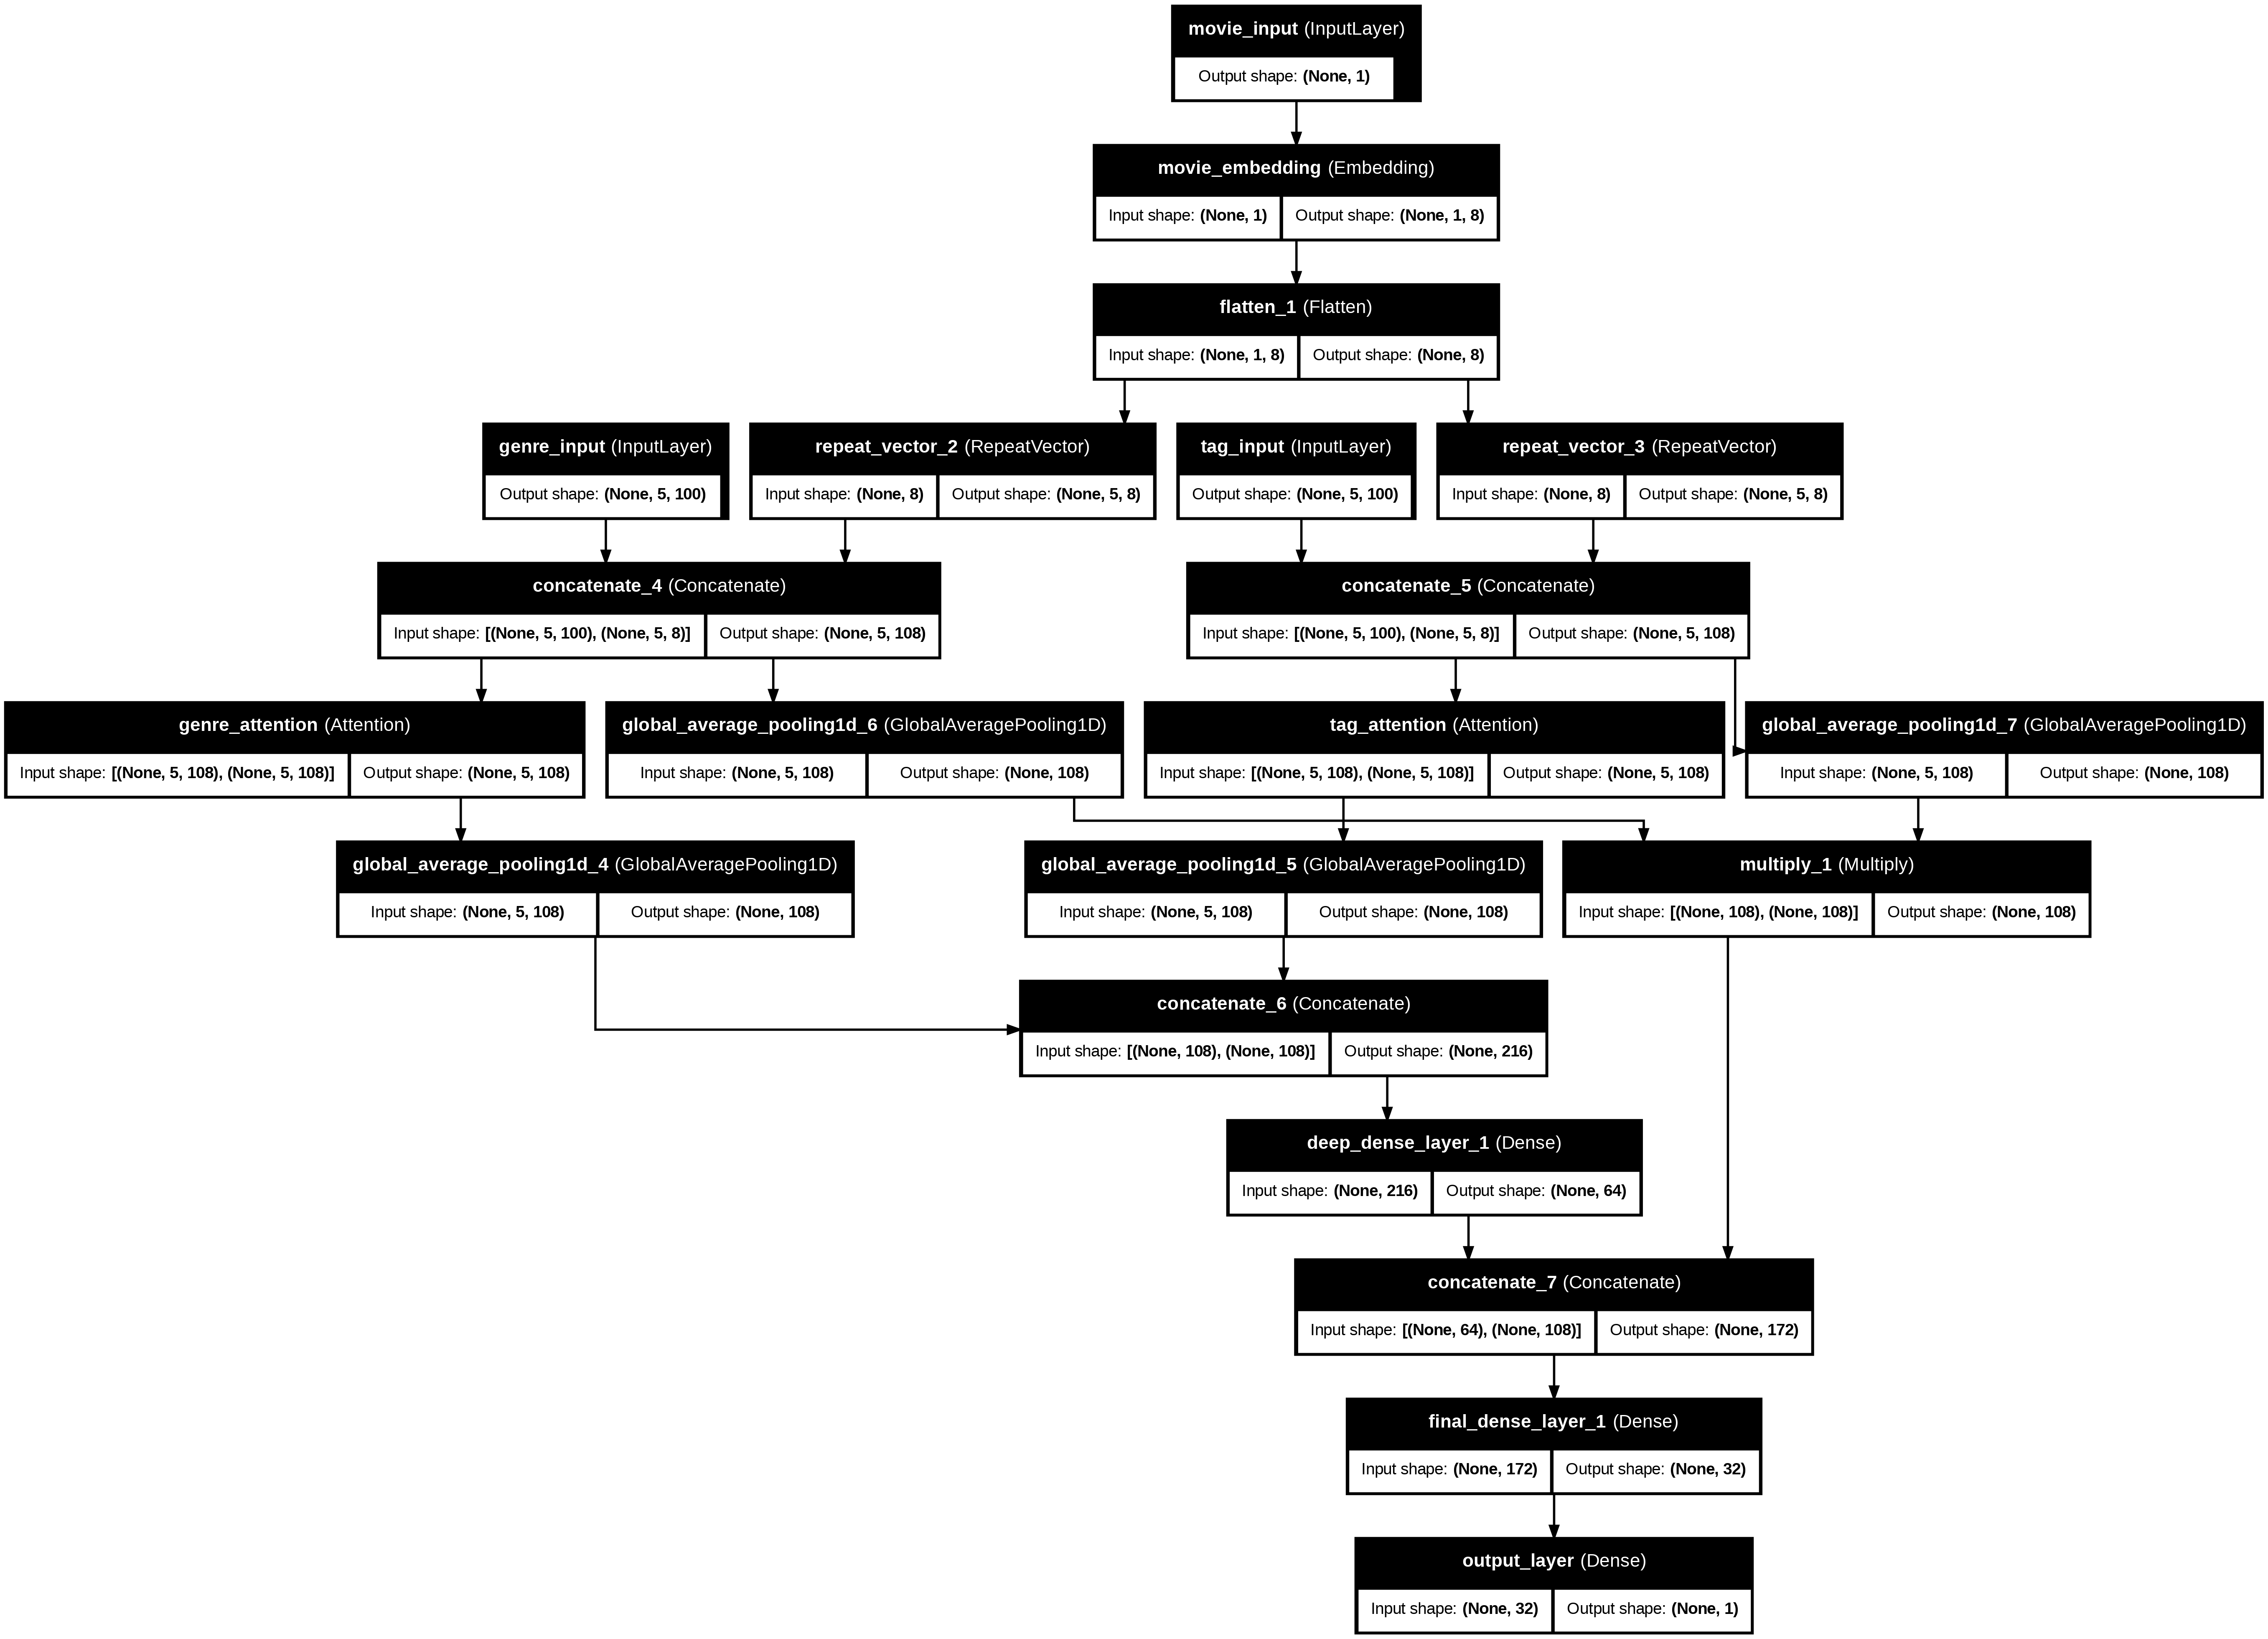

In [103]:
# Plot model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [196]:
'''from tensorflow.keras.callbacks import ReduceLROnPlateau

# Learning rate reduction callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_mean_absolute_error',
    factor=0.5,
    patience=1,
    min_lr=1e-5,
    verbose=1
)'''

# Compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

In [197]:
EPOCHS = 30
BATCH_SIZE = 128

history = model.fit(
    X_train,y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/30
940/940 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 5.0553 - mean_absolute_error: 1.5437 - val_loss: 2.3260 - val_mean_absolute_error: 0.9834
Epoch 2/30
940/940 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.8515 - mean_absolute_error: 0.7985 - val_loss: 0.9417 - val_mean_absolute_error: 0.3860
Epoch 3/30
940/940 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9135 - mean_absolute_error: 0.4087 - val_loss: 0.6630 - val_mean_absolute_error: 0.2806
Epoch 4/30
940/940 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.6457 - mean_absolute_error: 0.3236 - val_loss: 0.5006 - val_mean_absolute_error: 0.2473
Epoch 5/30
940/940 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.4881 - mean_absolute_error: 0.2805 - val_loss: 0.4044 - val_mean_absolute_error: 0.2271
Epoch 6/30
940/940 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.3834 - mean_absolute_error: 0.2540 - val_loss: 0.3188 - val_mean_absolute_error: 0.1941
Epoch 7/30
940/940 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3087 - mean_absolute_error: 0.2319 - 

In [198]:
import json
import os

results = {
    'Deep_dense_layer':'(64,)',
    'Final_dense_layer':'(32,)',
    'Dropout units': dropout_unit,
    'L2 Regularization': regularization_strength,
    'training_loss': history.history['loss'][-1],
    'training_mae': history.history['mean_absolute_error'][-1],
    'val_loss': history.history['val_loss'][-1],
    'val_mae': history.history['val_mean_absolute_error'][-1]
}


file_path = '/content/drive/MyDrive/ml-32m/training_results.json'

# Check if the file exists
if os.path.exists(file_path):
    # If it exists, load the existing data
    with open(file_path, 'r') as f:
        existing_data = json.load(f)

    # Append the new results to the existing data
    if isinstance(existing_data, list): #check if the data is already in list format
        existing_data.append(results)
    else:
        existing_data = [existing_data, results] # if not in the list, create a list


else:
    # If it doesn't exist, create a new list with the results
    existing_data = [results]

# Write the updated data back to the file
with open(file_path, 'w') as f:
    json.dump(existing_data, f, indent=4)

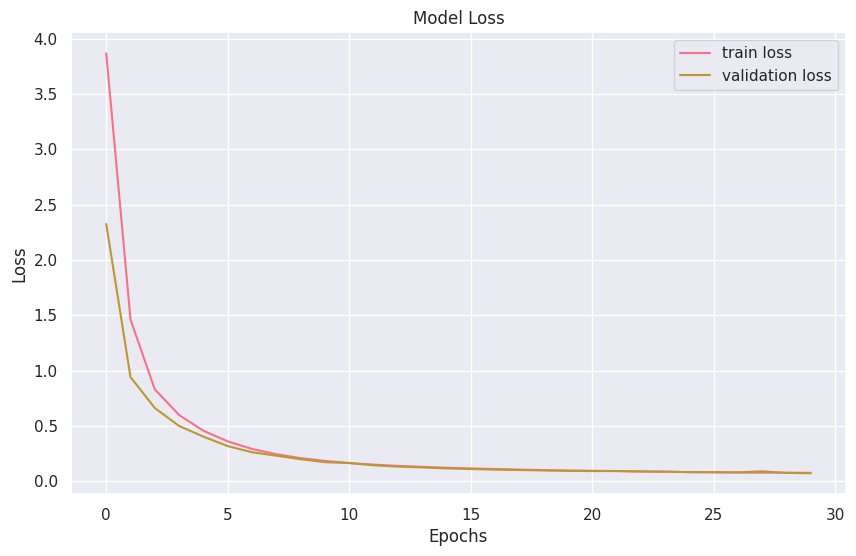

In [199]:
# Plot loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label="train loss")
plt.plot(history.history['val_loss'], label="validation loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

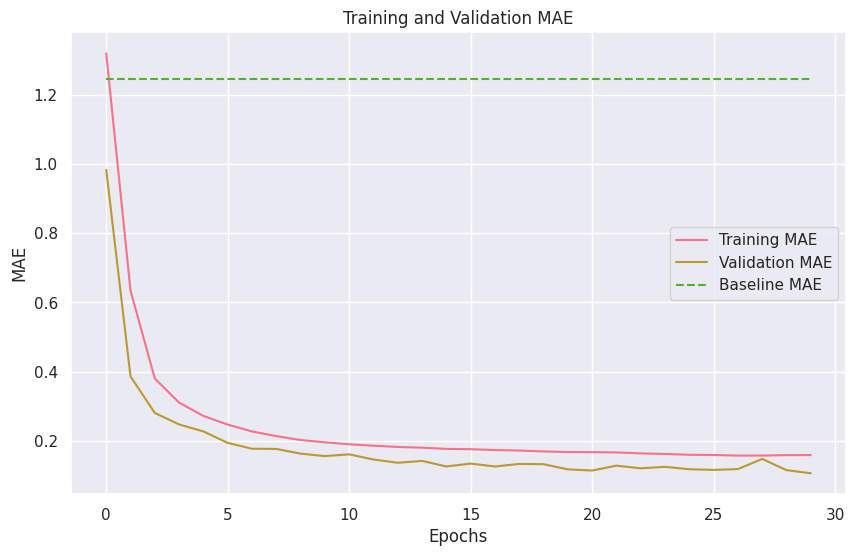

In [200]:
# Extract MAE values
training_mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']
baseline_mae = mean_absolute_error(y_val, [y_val.mean()] * len(y_val))
baseline_mae_list = [baseline_mae] * len(training_mae)  # Create a list of the baseline MAE


# Plot the MAE
plt.figure(figsize=(10, 6))
plt.plot(training_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.plot(baseline_mae_list, ls='--', label='Baseline MAE')
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

In [201]:
# Save model
model.save('/content/drive/MyDrive/ml-32m/model.keras')

In [202]:
# Evaluate the model
val_loss, val_mae = model.evaluate([X_movie_id_val, X_genres_val, X_tags_val], y_val, verbose=1)
print(f"Val Loss: {val_loss:.4f}")
print(f"Val Mean Absolute Error: {val_mae:.4f}")


940/940 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0718 - mean_absolute_error: 0.1038
Val Loss: 0.0736
Val Mean Absolute Error: 0.1062


In [205]:
# Predict on validation or test data
predictions = model.predict([X_movie_id_val, X_genres_val, X_tags_val])

# Reshape predictions if necessary (depending on output layer)
predictions = predictions.flatten()

# Example of displaying some predictions
for i in np.arange(5):
    print(f"Actual Rating: {y_val[i]:.1f}, Predicted Rating: {predictions[i]:.2f}")


940/940 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
Actual Rating: 1.0, Predicted Rating: 1.05
Actual Rating: 4.5, Predicted Rating: 4.47
Actual Rating: 1.5, Predicted Rating: 1.53
Actual Rating: 3.5, Predicted Rating: 3.21
Actual Rating: 1.5, Predicted Rating: 1.59


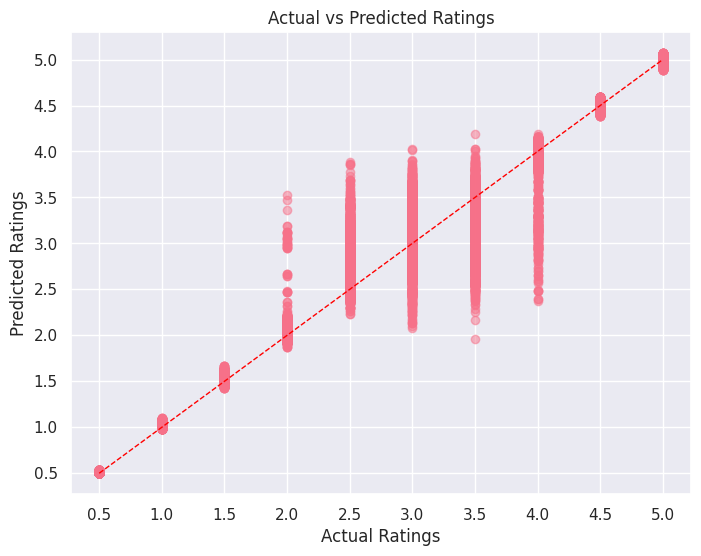

In [206]:
# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_val, predictions, alpha=0.5)
plt.plot([0.5, 5], [0.5, 5], color='red', linestyle='--', linewidth=1)  # Ideal line
ticks = np.linspace(0.5, 5.0, num=10)
plt.xticks(ticks)
plt.yticks(ticks)
plt.title("Actual vs Predicted Ratings")
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.show()

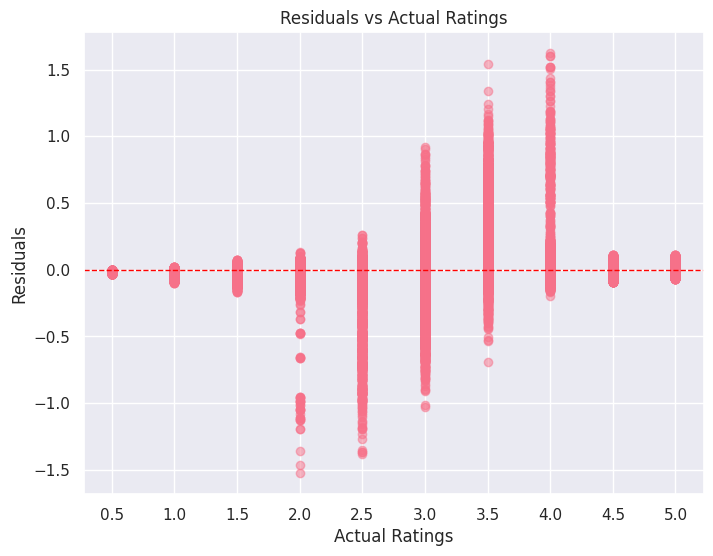

In [207]:
residuals = y_val - predictions

plt.figure(figsize=(8, 6))
plt.scatter(y_val, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)
plt.xticks(ticks)
plt.title("Residuals vs Actual Ratings")
plt.xlabel("Actual Ratings")
plt.ylabel("Residuals")
plt.show()


## Feature Analysis

In [90]:
# Load saved model
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/ml-32m/model.keras')

In [92]:
import shap

def predict_wrapper(X):
    """
    Wrapper function to make model predictions compatible with SHAP
    X is expected to be a 2D numpy array with concatenated columns: [movie_id, flattened_genres, flattened_tags]
    """
    # Ensure X is properly sliced
    num_movies = 1
    num_genres = 5 * 100  # Flattened genres
    num_tags = 5 * 100    # Flattened tags

    movie_ids = X[:, :num_movies]  # Movie IDs
    genres = X[:, num_movies:num_movies + num_genres].reshape(-1, 5, 100)  # Reshape to (5, 100)
    tags = X[:, num_movies + num_genres:].reshape(-1, 5, 100)  # Reshape to (5, 100)

    # Return predictions
    return model.predict([movie_ids, genres, tags]).flatten()



# Flatten the genre and tag embeddings for concatenation
X_genres_val_flattened = X_genres_val.reshape(X_genres_val.shape[0], -1)  # (num_samples, 5 * 100)
X_tags_val_flattened = X_tags_val.reshape(X_tags_val.shape[0], -1)        # (num_samples, 5 * 100)

# Combine validation data into a single 2D array
X_combined = np.hstack([X_movie_id_val.reshape(-1, 1),
                        X_genres_val_flattened,
                        X_tags_val_flattened])

# Define SHAP explainer with the updated combined data
explainer = shap.KernelExplainer(predict_wrapper, X_combined[:50])

# Calculate SHAP values for a sample of validation data
shap_values = explainer.shap_values(X_combined[:200])


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 515ms/step


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
6329/6329 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6329/6329 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6329/6329 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6329/6329 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6329/6329 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
6329/6329 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6329/6329 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
6329/6329 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
6329/6329 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6329/6329 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
6329/6329 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6329/6329 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━

In [93]:
shap_values.shape

(200, 1001)

In [94]:
X_movie_id_val.flatten().shape

(30070,)

In [95]:
# Prepare the list of unique genres and tags from the validation set
movie_ids_val = X_movie_id_val.flatten()
final_df_val = final_df[final_df['movieId'].isin(movie_ids_val)]

# Check the number of validation samples and SHAP values
num_samples = shap_values.shape[0]
num_features = shap_values.shape[1]

# Ensure that final_df_val has more than 100 rows
final_df_val = final_df_val.iloc[:num_samples]

# Adjust indices based on where your genre and tag features start
genre_shap = shap_values[:, 1:1001]  # Assuming columns 1 to 1000 correspond to genre and tag features

# Create mappings for genres and tags based on unique features
unique_genres = list(set([genre for genres in final_df_val['genres'].apply(clean_and_split) for genre in genres]))
unique_tags = list(set([tag for tags in final_df_val['top_tags'].apply(clean_and_split) for tag in tags]))

# Map SHAP values to genres and tags
genre_shap_mapping = {genre: {'impact': [], 'direction': []} for genre in unique_genres}
tag_shap_mapping = {tag: {'impact': [], 'direction': []} for tag in unique_tags}

# Initialize mapping for genres and tags with empty lists
genre_shap_mapping = {genre: [] for genre in unique_genres}
tag_shap_mapping = {tag: [] for tag in unique_tags}

# Loop through the validation data to map SHAP values to genres and tags
for i, row in final_df_val.iterrows():
    if i >= num_samples:
        break  # Stop if we exceed the available SHAP values

    # Extract genres and tags for the current validation instance
    movie_genres = clean_and_split(row['genres'])
    movie_tags = clean_and_split(row['top_tags'])

    # Add SHAP values for genres
    for genre in movie_genres:
        if genre in genre_shap_mapping:
            # Append all SHAP values directly without averaging
            genre_shap_mapping[genre].append(genre_shap[i].tolist())  # Append the list of SHAP values for this instance

    # Add SHAP values for tags
    for tag in movie_tags:
        if tag in tag_shap_mapping:
            # Append all SHAP values directly without averaging
            tag_shap_mapping[tag].append(genre_shap[i].tolist())  # Append the list of SHAP values for this instance

# Flatten the lists for each genre and tag
genre_shap_mapping = {genre: [val for sublist in values for val in sublist] for genre, values in genre_shap_mapping.items()}
tag_shap_mapping = {tag: [val for sublist in values for val in sublist] for tag, values in tag_shap_mapping.items()}

# Calculate mean importance and count
genre_importance = {}
for genre, values in genre_shap_mapping.items():
    if values:
        genre_importance[genre] = {
            'impact': np.mean(values),
            'count': len([x for x in final_df_val['genres'].apply(clean_and_split) if genre in x])
        }

tag_importance = {}
for tag, values in tag_shap_mapping.items():
    if values:
        tag_importance[tag] = {
            'impact': np.mean(values),
            'count': len([x for x in final_df_val['top_tags'].apply(clean_and_split) if tag in x])
        }

# Convert to DataFrames
genre_df = pd.DataFrame.from_dict(genre_importance, orient='index')
genre_df['genre'] = genre_df.index
genre_df = genre_df.reset_index(drop=True)
genre_df = genre_df.sort_values('impact', ascending=False)

tag_df = pd.DataFrame.from_dict(tag_importance, orient='index')
tag_df['tag'] = tag_df.index
tag_df = tag_df.reset_index(drop=True)
tag_df = tag_df.sort_values('impact', ascending=False)

# Print results
print("Top genres by SHAP impact:")
print(genre_df)
print("\nTop tags by SHAP impact:")
print(tag_df)

Top genres by SHAP impact:
          impact  count        genre
2   1.910186e-04      4    Animation
17  1.747185e-04      9     Children
7   1.290687e-04     10      Fantasy
13  8.800888e-05      6  Documentary
6   5.928544e-05     17    Adventure
5   4.066246e-05     77       Comedy
4   5.172007e-06      3      Western
3   3.794163e-06      1      Musical
0  -7.345627e-07    111        Drama
12 -1.540144e-06      9      Mystery
15 -2.325966e-06     44      Romance
8  -9.616679e-06     21        Crime
16 -9.775832e-06     11       Sci-Fi
14 -1.311769e-05     30       Action
9  -1.632485e-05     10       Horror
1  -3.144214e-05     36     Thriller
11 -7.678222e-05      1    Film-Noir
10 -9.749512e-05      5          War

Top tags by SHAP impact:
       impact  count                     tag
140  0.000227      1                 camelot
174  0.000227      1        arthurian legend
0    0.000207      4                   actor
164  0.000207      1                  hamlet
41   0.000207      

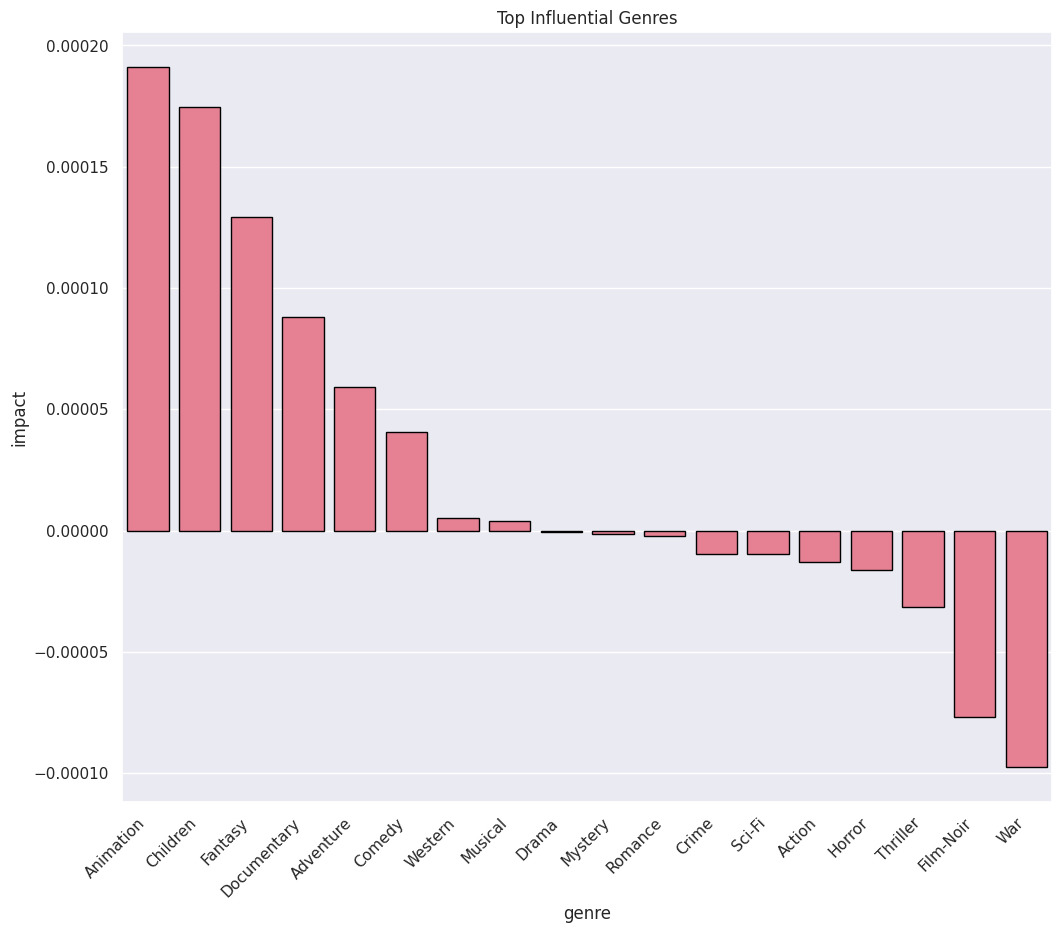

In [96]:
# Genres
plt.figure(figsize=(12, 10))
sns.barplot(x='genre', y='impact', data=genre_df)
plt.title('Top Influential Genres')
plt.xticks(rotation=45, ha='right')
plt.savefig('shap_genre.png', dpi=300, bbox_inches="tight")
plt.show()

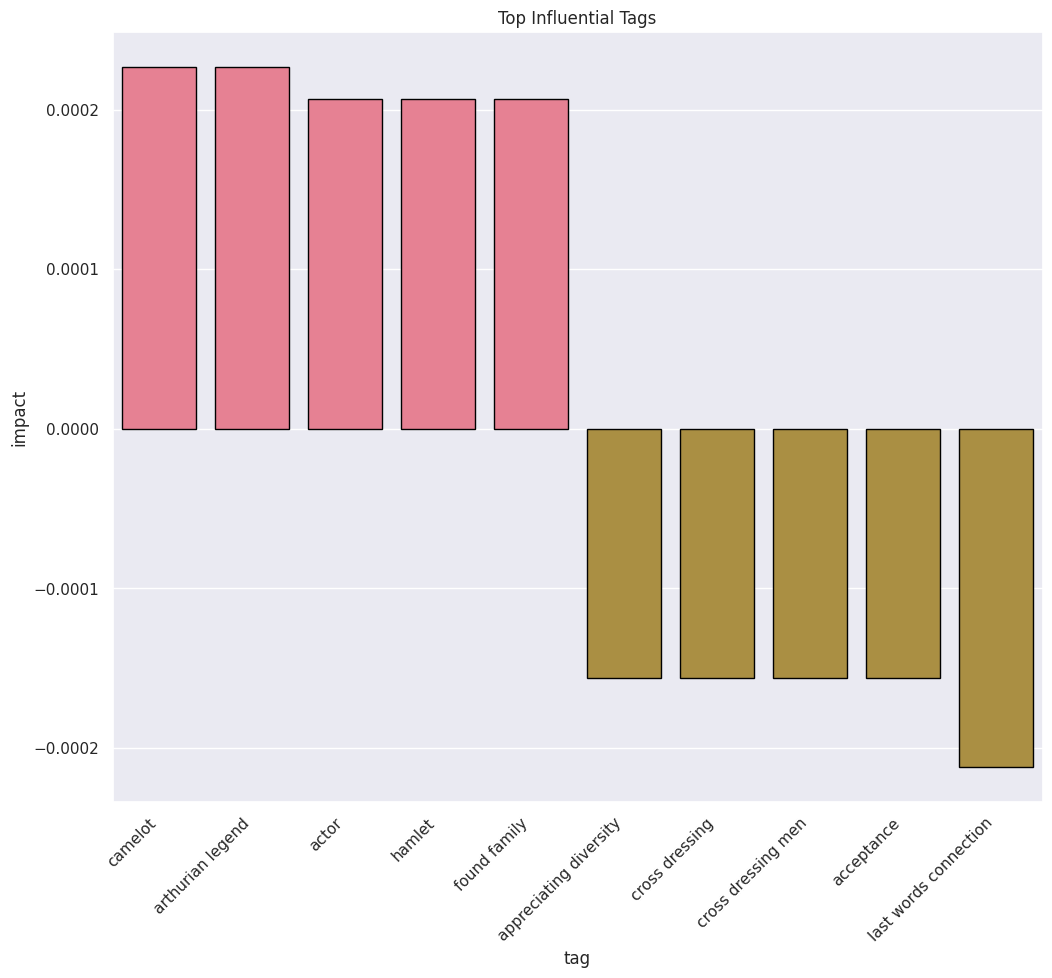

In [97]:
# Tags
plt.figure(figsize=(12, 10))
sns.barplot(x='tag', y='impact', data=tag_df.head(5))
sns.barplot(x='tag', y='impact', data=tag_df.tail(5))
plt.title('Top Influential Tags')
plt.xticks(rotation=45, ha='right')
plt.savefig('shap_tags.png', dpi=300, bbox_inches="tight")
plt.show()
